# IMPORTS

In [1]:
import math
import warnings
import datetime
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from matplotlib import pyplot as plt
from scipy import stats as ss
from boruta import BorutaPy

from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

In [2]:
#ajuste na visualização dos gráficos
from IPython.core.display import HTML


%matplotlib inline
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )
sns.set()


# CARREGAMENTO DOS DADOS

In [3]:
dfSales = pd.read_csv('../data/train.csv',low_memory=False)
print("Features:{}\n\nLinhas:{}\n\nColunas:{}".format(dfSales.columns,dfSales.shape[0],dfSales.shape[1]))

Features:Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

Linhas:1017209

Colunas:9


In [4]:
dfStores = pd.read_csv('../data/store.csv',low_memory=False)
print("Features:{}\n\nLinhas:{}\n\nColunas:{}".format(dfStores.columns,dfStores.shape[0],dfStores.shape[1]))

Features:Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Linhas:1115

Colunas:10


In [5]:
dfSales.head(10)#venda das lojas por data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [6]:
dfStores.head(10)#perfil de cada loja

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [7]:
dfRaw = pd.merge (dfSales , dfStores, how = 'left', on = 'Store')#merge dos dados pelas lojas
dfRaw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
print("Features:{}\n\nLinhas:{}\n\nColunas:{}".format(dfRaw.columns,dfRaw.shape[0],dfRaw.shape[1]))

Features:Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Linhas:1017209

Colunas:18


In [9]:
dfRaw['Date'] = pd.to_datetime(dfRaw['Date'])
dfRaw.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [10]:
#split 2 meses recentes para teste (data mais recente do dataset de treino: 2015-07-31)
#split nesse momento para evitar data leakage
#tempo de 2 meses escolhidos por ser um periodo similar a 6 semanas(dataset de teste) e pequeno em relação ao tamanho do dataset de treino
dfTest = dfRaw[(dfRaw['Date']>"2015-05-31")]
dfRaw = dfRaw[(dfRaw['Date']<"2015-06-01")]
dfRaw.shape

(949194, 18)

In [11]:
949194/1017209
#porporção treino:teste 7:93[%](comumente 20:80[%])

0.9331356682844921

# LIMPEZA DOS DADOS

In [12]:
df1 = dfRaw.copy()

In [13]:
df1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [14]:
#checagem dos dados faltantes
df1.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2459
CompetitionOpenSinceMonth    301754
CompetitionOpenSinceYear     301754
Promo2                            0
Promo2SinceWeek              474847
Promo2SinceYear              474847
PromoInterval                474847
dtype: int64

In [15]:
#preencher dados faltantes
df1['CompetitionDistance'] = df1['CompetitionDistance'].apply(lambda x: 100000.0 if math.isnan(x) else x) 
#atribuindo um valor mais alto que o maior encontrado pelo df1['CompetitionDistance'].max(): 75860.0

df1['CompetitionOpenSinceMonth'] = df1.apply(lambda x: x['Date'].month if math.isnan(x['CompetitionOpenSinceMonth']) else x['CompetitionOpenSinceMonth'], axis=1)
#atribuindo o mesmo mes caso nao tenha dados do historico de concorrencia, axis 1 quando acessamos mais de 1 coluna
#assumir valores para contribuir em dados de comportamento das vendas com competidor
#existem dados que mostram que tem concorrencia mas nao tem histórico
#caso de algum problema de performance por causa desse fator, alteramos no próximo ciclo

df1['CompetitionOpenSinceYear'] = df1.apply(lambda x: x['Date'].year if math.isnan(x['CompetitionOpenSinceYear']) else x['CompetitionOpenSinceYear'], axis=1)

df1['Promo2SinceWeek'] = df1.apply(lambda x: x['Date'].week if math.isnan(x['Promo2SinceWeek']) else x['Promo2SinceWeek'], axis=1)

df1['Promo2SinceYear'] = df1.apply(lambda x: x['Date'].year if math.isnan(x['Promo2SinceYear']) else x['Promo2SinceYear'], axis=1)

#para PromoInterval, em casos de dados faltantes a loja não esta participando
#PromoInterval mostra os meses (abreviados e separados por vírgula) que tem promoção no ano, ex: Feb,May,Aug,Nov
#conferir a data atual com os meses do PromoInterval e marcar se teve ou nao alguma promoção

#dicionario para usar como mascara na identificação dos meses
monthMap = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['PromoInterval'].fillna(0,inplace=True)

#coluna nova extraindo o mes da data
df1['MonthMap'] = df1['Date'].dt.month.map(monthMap)

#coluna nova mostrando a participação da loja na promo 2
df1['IsPromo'] = df1[['PromoInterval','MonthMap']].apply(lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['MonthMap'] in x['PromoInterval'].split(',') else 0, axis =1)

In [16]:
#checagem dos dados faltantes após a limpeza dos dados
df1.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
MonthMap                     0
IsPromo                      0
dtype: int64

In [17]:
df1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
MonthMap                             object
IsPromo                               int64
dtype: object

In [18]:
#casting dos tipos CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceYear, Promo2SinceYear de float para int
df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype(int)
df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype(int)

df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype(int)
df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype(int)

### FUNÇÃO DE LIMPEZA

In [19]:
def dataClean(df):
    df['CompetitionDistance'] = df['CompetitionDistance'].apply(lambda x: 100000.0 if math.isnan(x) else x) 
    df['CompetitionOpenSinceMonth'] = df.apply(lambda x: x['Date'].month if math.isnan(x['CompetitionOpenSinceMonth']) else x['CompetitionOpenSinceMonth'], axis=1)
    df['CompetitionOpenSinceYear'] = df.apply(lambda x: x['Date'].year if math.isnan(x['CompetitionOpenSinceYear']) else x['CompetitionOpenSinceYear'], axis=1)
    df['Promo2SinceWeek'] = df.apply(lambda x: x['Date'].week if math.isnan(x['Promo2SinceWeek']) else x['Promo2SinceWeek'], axis=1)
    df['Promo2SinceYear'] = df.apply(lambda x: x['Date'].year if math.isnan(x['Promo2SinceYear']) else x['Promo2SinceYear'], axis=1)
    monthMap = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df['PromoInterval'].fillna(0,inplace=True)
    df['MonthMap'] = df['Date'].dt.month.map(monthMap)
    df['IsPromo'] = df[['PromoInterval','MonthMap']].apply(lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['MonthMap'] in x['PromoInterval'].split(',') else 0, axis =1)
    df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].astype(int)
    df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].astype(int)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].astype(int)
    df['Promo2SinceYear'] = df['Promo2SinceYear'].astype(int)
    return df

# ESTATÍSTICA DESCRITIVA DOS DADOS

In [20]:
#Separação dos dados em variáveis categóricas e variáveis numéricas

numAtt = df1.select_dtypes(include = ['int64','float64'])
catAtt = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

In [21]:
numAtt.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,IsPromo
68015,1,7,0,0,0,0,0,1270.0,9,2008,0,22,2015,0
68016,2,7,0,0,0,0,0,570.0,11,2007,1,13,2010,0
68017,3,7,0,0,0,0,0,14130.0,12,2006,1,14,2011,0
68018,4,7,0,0,0,0,0,620.0,9,2009,0,22,2015,0
68019,5,7,0,0,0,0,0,29910.0,4,2015,0,22,2015,0


In [22]:
catAtt.head()

,StateHoliday,StoreType,Assortment,PromoInterval,MonthMap
68015,0,c,a,0,May
68016,0,a,a,"Jan,Apr,Jul,Oct",May
68017,0,a,a,"Jan,Apr,Jul,Oct",May
68018,0,c,c,0,May
68019,0,a,a,0,May


In [23]:
desStat = numAtt.agg(["mean","median","std","min","max","skew","kurtosis"]).T
desStat

,mean,median,std,min,max,skew,kurtosis
Store,558.460519,558.0,321.911209,1.0,1115.0,-0.001023,-1.200561
DayOfWeek,4.004095,4.0,1.998670,1.0,7.0,-0.001959,-1.248781
Sales,5745.395182,5720.0,3851.817831,0.0,38722.0,0.645153,1.774439
Customers,632.265625,609.0,465.677514,0.0,7388.0,1.584984,6.985968
Open,0.827840,1.0,0.377519,0.0,1.0,-1.736816,1.016533
Promo,0.379485,0.0,0.485259,0.0,1.0,0.496704,-1.753289
SchoolHoliday,0.176051,0.0,0.380864,0.0,1.0,1.701127,0.893836
CompetitionDistance,5676.880027,2330.0,9085.223522,20.0,100000.0,4.632513,35.223350
CompetitionOpenSinceMonth,6.771775,7.0,3.350794,1.0,12.0,-0.040246,-1.268244
CompetitionOpenSinceYear,2010.299468,2012.0,5.485857,1900.0,2015.0,-7.260957,124.945371


In [24]:
catAtt.apply(lambda x: x.unique().shape[0])

StateHoliday      4
StoreType         4
Assortment        3
PromoInterval     4
MonthMap         12
dtype: int64

In [25]:
aux1 = df1[(df1['StateHoliday']!='0') & (df1['Sales']>0)]

<AxesSubplot: xlabel='Assortment', ylabel='Sales'>

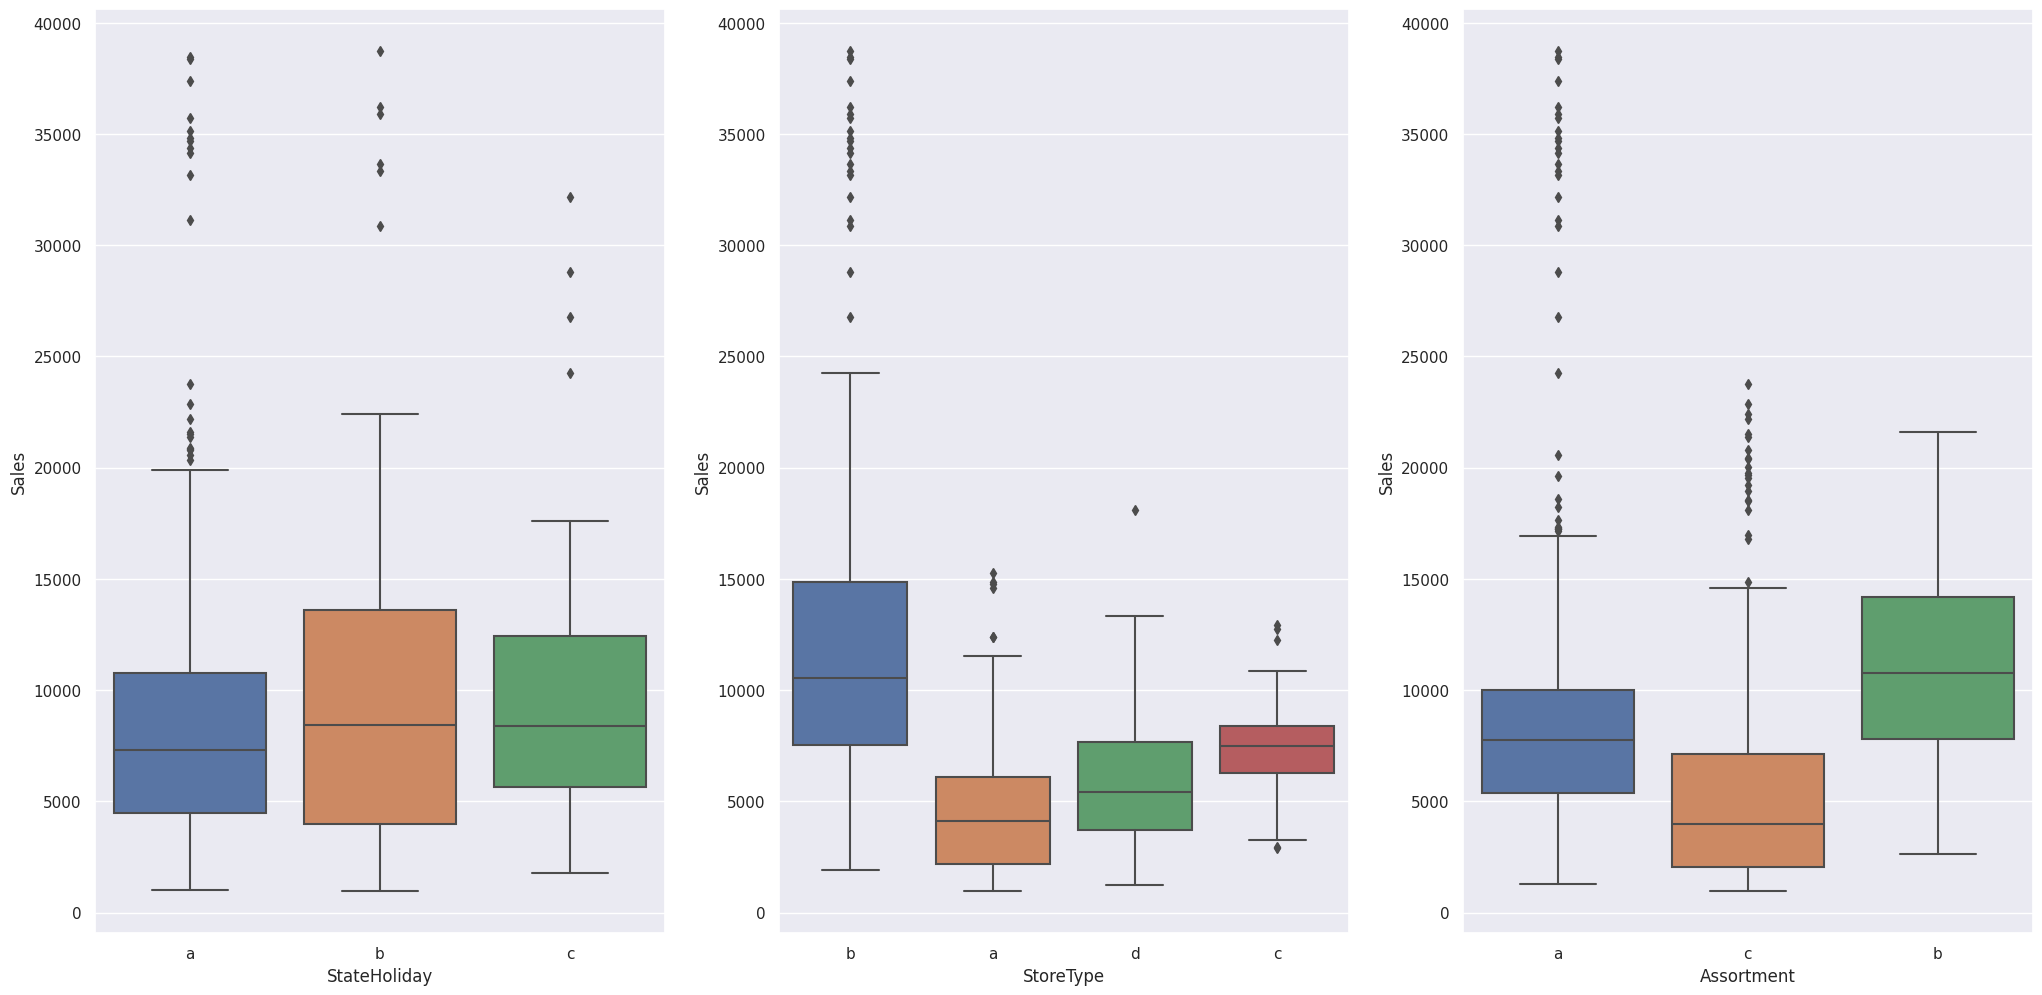

In [26]:
#Mostrar o quanto a variavel resposta(vendas) está distribuída dentro das variáveis categóricas
plt.subplot(1,3,1)
sns.boxplot(x='StateHoliday',y='Sales',data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x='StoreType',y='Sales',data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x='Assortment',y='Sales',data = aux1)

# FEATURE ENGINEERING

### DERIVAÇÃO DE VARIÁVEIS

In [27]:
df2 = df1.copy()

In [28]:
#derivar variáveis
df2['Year'] = df2['Date'].dt.year
df2['Month'] = df2['Date'].dt.month
df2['Day'] = df2['Date'].dt.day
df2['WeekOfYear'] = df2['Date'].dt.weekofyear
df2['YearWeek'] = df2['Date'].dt.strftime("%Y-%W")

#nova coluna CompetitionSince criada com dados do CompetitionOpenSinceYear e CompetitionOpenSinceMonth
df2['CompetitionSince'] = df2.apply(lambda x: datetime.datetime(year = x['CompetitionOpenSinceYear'],month=x['CompetitionOpenSinceMonth'],day=1),axis=1)

#periodo de presença de competidores em meses
#apply(lambda x: x.days) para limpar as informações da diferença
df2['CompetitionTimeMonth'] = ((df2['Date']-df2['CompetitionSince'])/30).apply(lambda x: x.days).astype(int)

#período da promo2 ano-semana (ajuste da formatação em string)
df2['Promo2Since'] = df2['Promo2SinceYear'].astype(str)+'-'+df2['Promo2SinceWeek'].astype(str)

#strptime(<string a ser convertida>, <formato>) converte str para datetime
#%w e -1 indica para o compilador segunda-feira como dia da semana
#subtração de 7 dias para nao dar valores negativos para datas promoções recentes(a menos de 1 semana)
df2['Promo2Since'] = df2['Promo2Since'].apply(lambda x: datetime.datetime.strptime(x + '-1',"%Y-%W-%w"))

#período da promo2 em semanas
df2['Promo2TimeWeek'] = ((df2['Date']-df2['Promo2Since'])/7).apply(lambda x: x.days).astype(int)

In [29]:
#adicionar a descrição dos dados para melhor visualização
df2['Assortment'] = df2['Assortment'].apply(lambda x: 'basic' if x == 'a' 
                                                 else 'extra' if x == 'b' 
                                                 else 'extended')

df2['StateHoliday'] = df2 ['StateHoliday'].apply(lambda x: 'PublicHoliday' if x == 'a' 
                                                      else 'EasterHoliday' if x == 'b' 
                                                      else 'Christmas'     if x == 'c' 
                                                      else 'RegularDay')

### FILTRAGEM DE LINHAS E COLUNAS

In [30]:
df2.shape

(949194, 29)

In [31]:
#filtragem de linhas e colunas
df3 = df2.copy()

#lojas abertas e com a presença de valores da variável resposta
df3 = df3[(df3['Open']!= 0 ) & (df3['Sales']>0)]

#retirada de colunas ja derivadas e colunas usadas como mascara
#
dropMap = ['Customers','Open','PromoInterval','MonthMap']
df3 = df3.drop(dropMap,axis=1)
df3.shape

(785727, 25)

### FUNÇÃO FEATURE ENGINEERING

In [32]:
def featureEng(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['YearWeek'] = df['Date'].dt.strftime("%Y-%W")
    df['CompetitionSince'] = df.apply(lambda x: datetime.datetime(year = x['CompetitionOpenSinceYear'],month=x['CompetitionOpenSinceMonth'],day=1),axis=1)
    df['CompetitionTimeMonth'] = ((df['Date']-df['CompetitionSince'])/30).apply(lambda x: x.days).astype(int)
    df['Promo2Since'] = df['Promo2SinceYear'].astype(str)+'-'+df['Promo2SinceWeek'].astype(str)
    df['Promo2Since'] = df['Promo2Since'].apply(lambda x: datetime.datetime.strptime(x + '-1',"%Y-%W-%w"))
    df['Promo2TimeWeek'] = ((df['Date']-df['Promo2Since'])/7).apply(lambda x: x.days).astype(int)
    df['Assortment'] = df['Assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
    df['StateHoliday'] = df ['StateHoliday'].apply(lambda x: 'PublicHoliday' if x == 'a' else 'EasterHoliday' if x == 'b'  else 'Christmas' if x == 'c' else 'RegularDay')
    df = df[(df['Open']!= 0 ) & (df['Sales']>0)]
    dropMap = ['Customers','Open','PromoInterval','MonthMap']
    df = df.drop(dropMap,axis=1)
    return df

# ANÁLISE EXPLORATÓRIA DE DADOS

###  ANÁLISE UNIVARIADA (VARIÁVEL RESPOSTA )

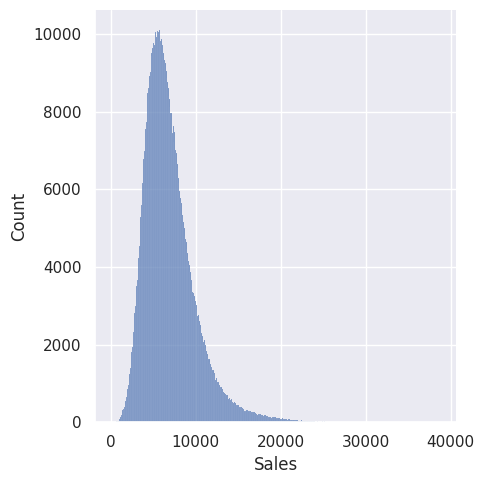

In [33]:
df4 = df3.copy('')
df4.to_csv('/home/aroldo/repos/dsprod/data/EDA.csv')
sns.displot(df4['Sales']);

### ANÁLISE BIVARIADA (VARIÁVEL RESPOSTA x OUTRAS FEATURES)

##### VENDAS x SORTIMENTO DAS LOJAS

<AxesSubplot: xlabel='Assortment', ylabel='count'>

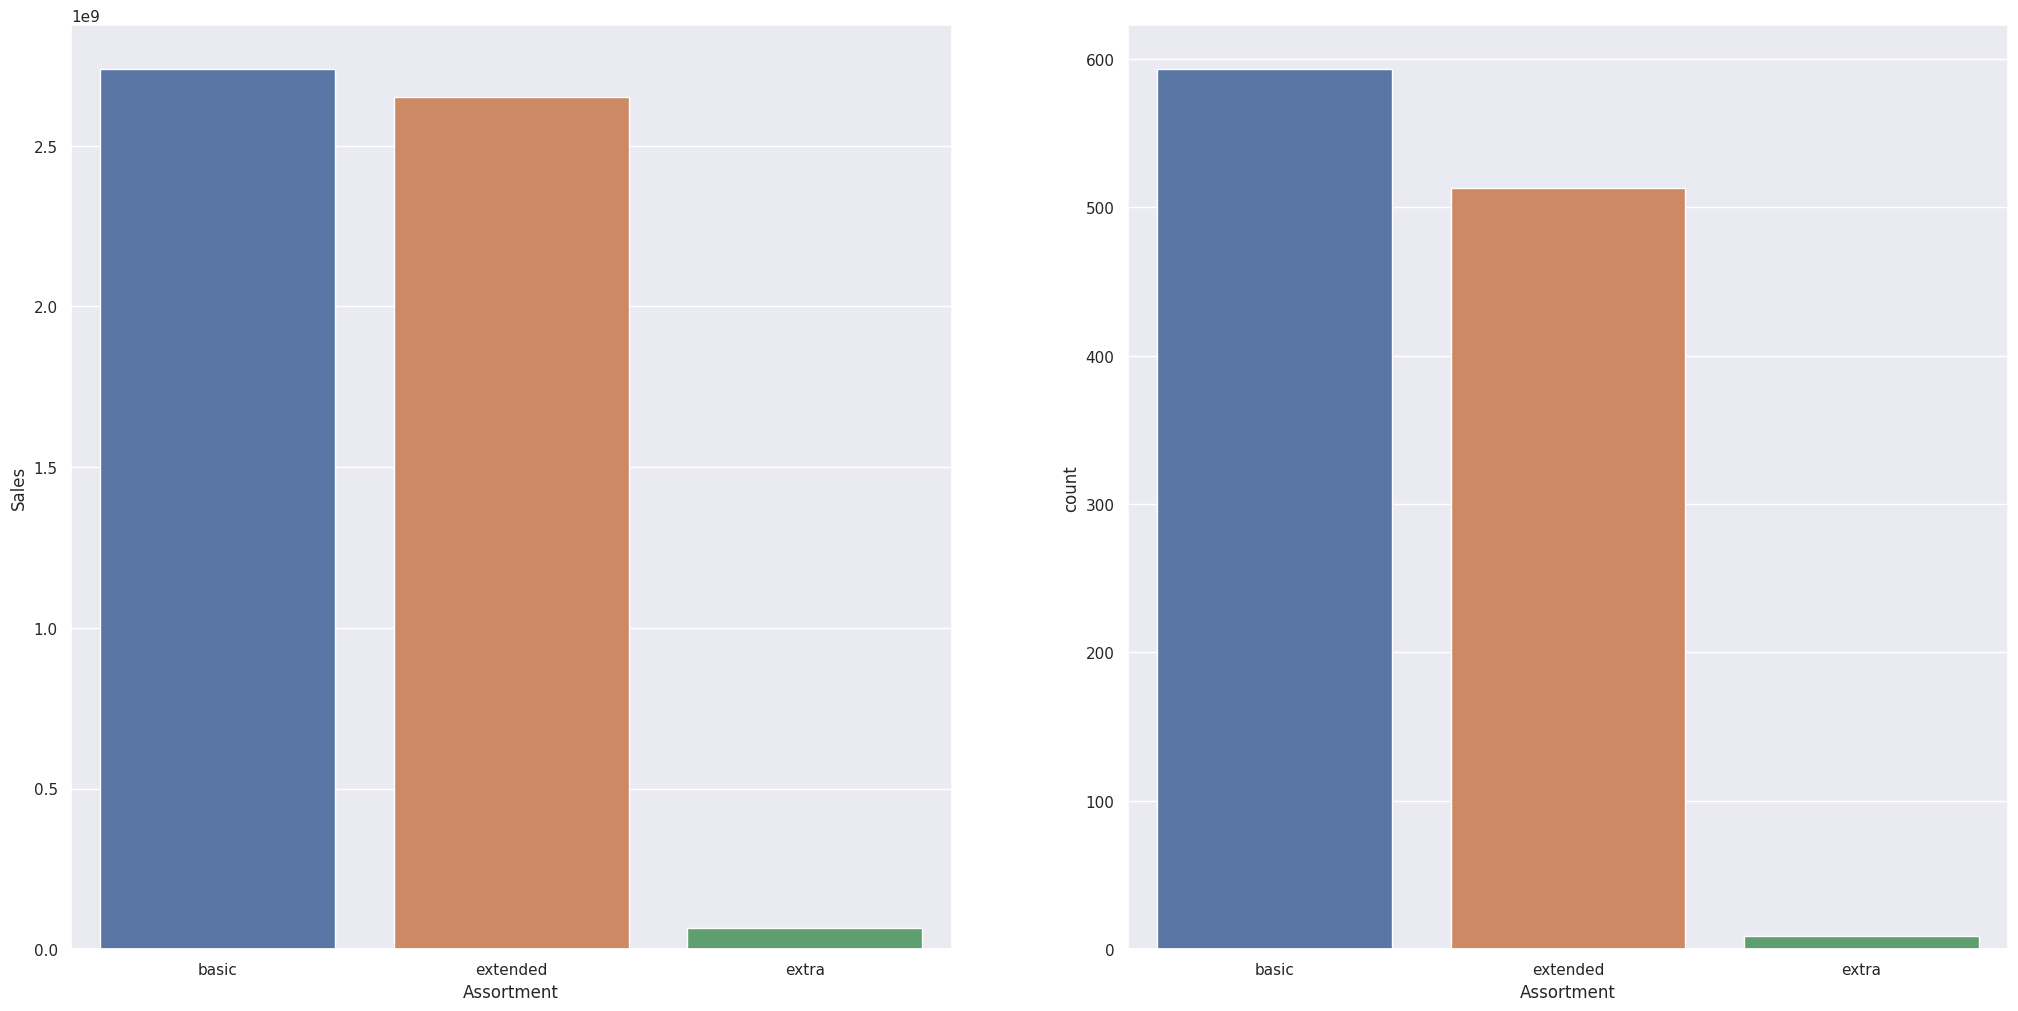

In [34]:
plt.subplot(1,2,1)
#volume de vendas por sortimento
aux1 = df4[['Assortment','Sales']].groupby('Assortment').sum().reset_index()
sns.barplot( x='Assortment', y='Sales', data=aux1 );

plt.subplot(1,2,2)
#quantidade de lojas por sortimento
aux2 = df4.drop_duplicates(subset=['Store'])
sns.countplot(x=aux2['Assortment'])

<AxesSubplot: xlabel='YearWeek'>

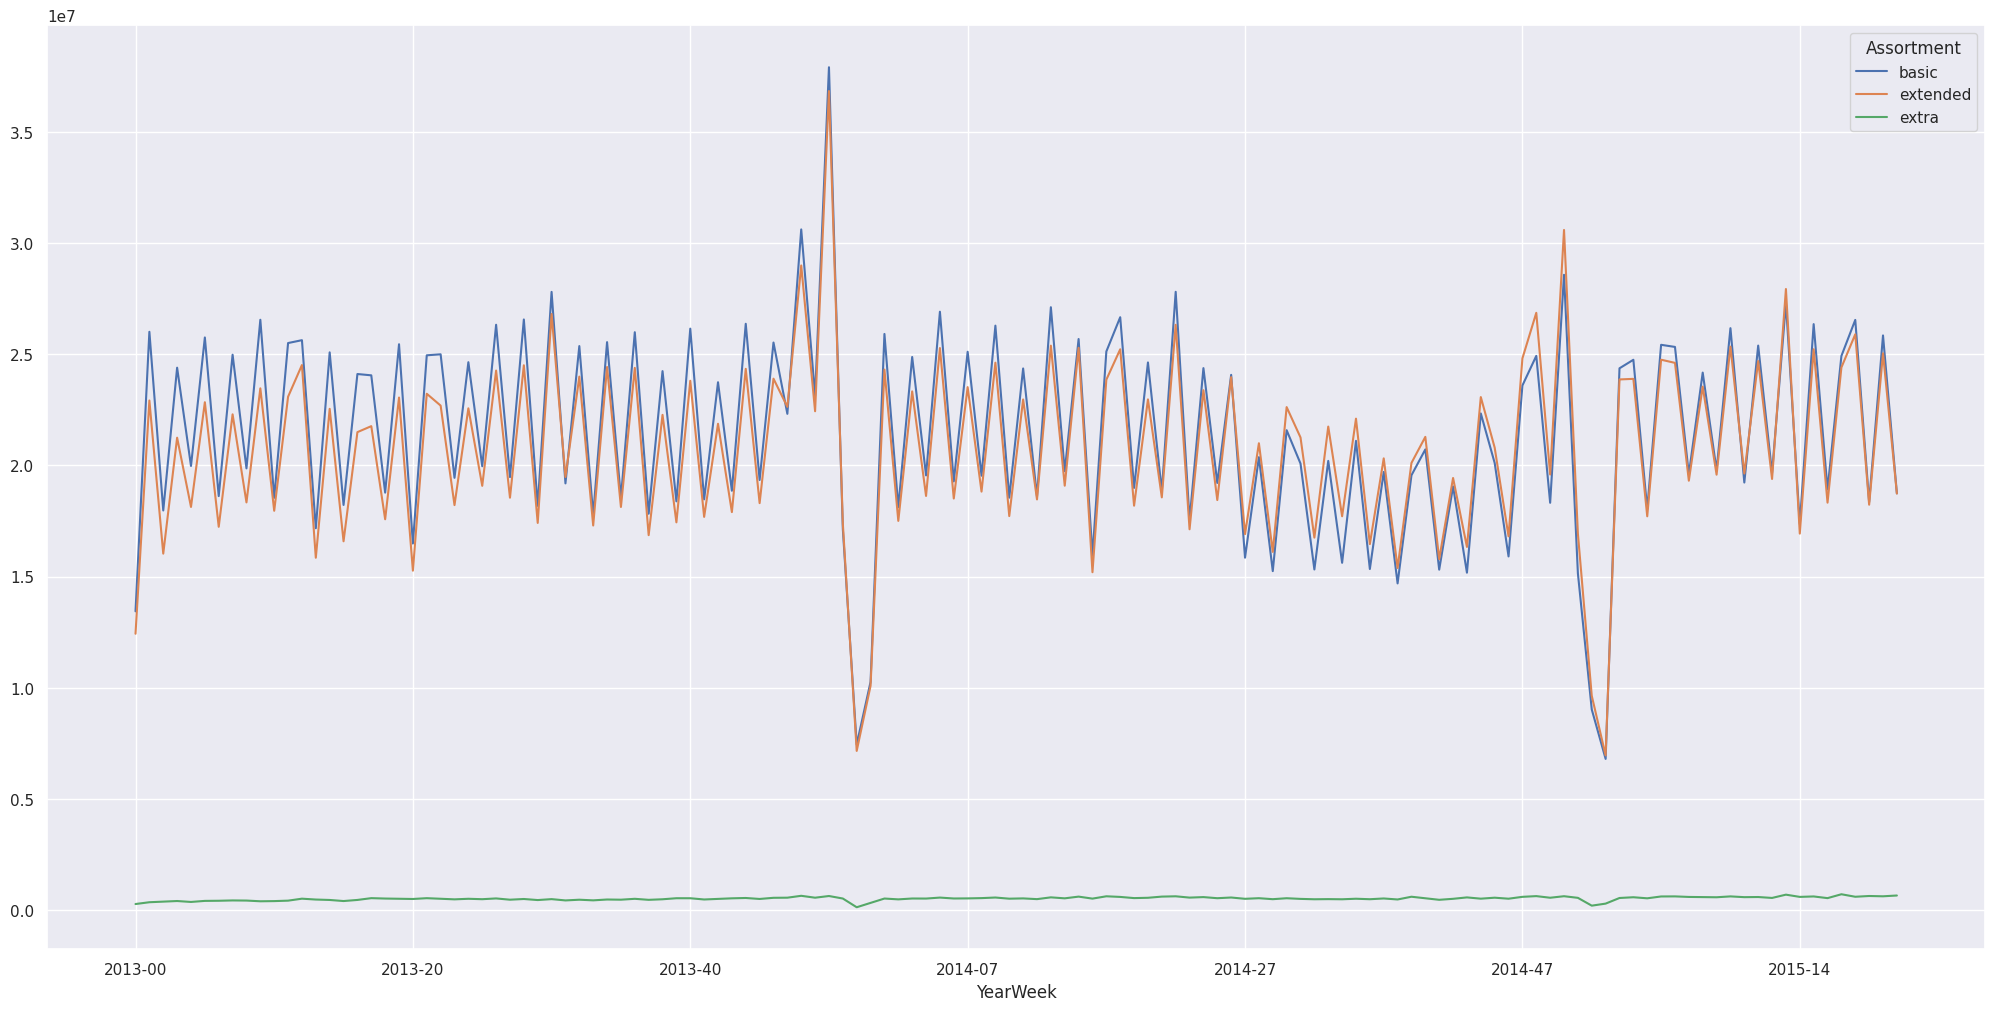

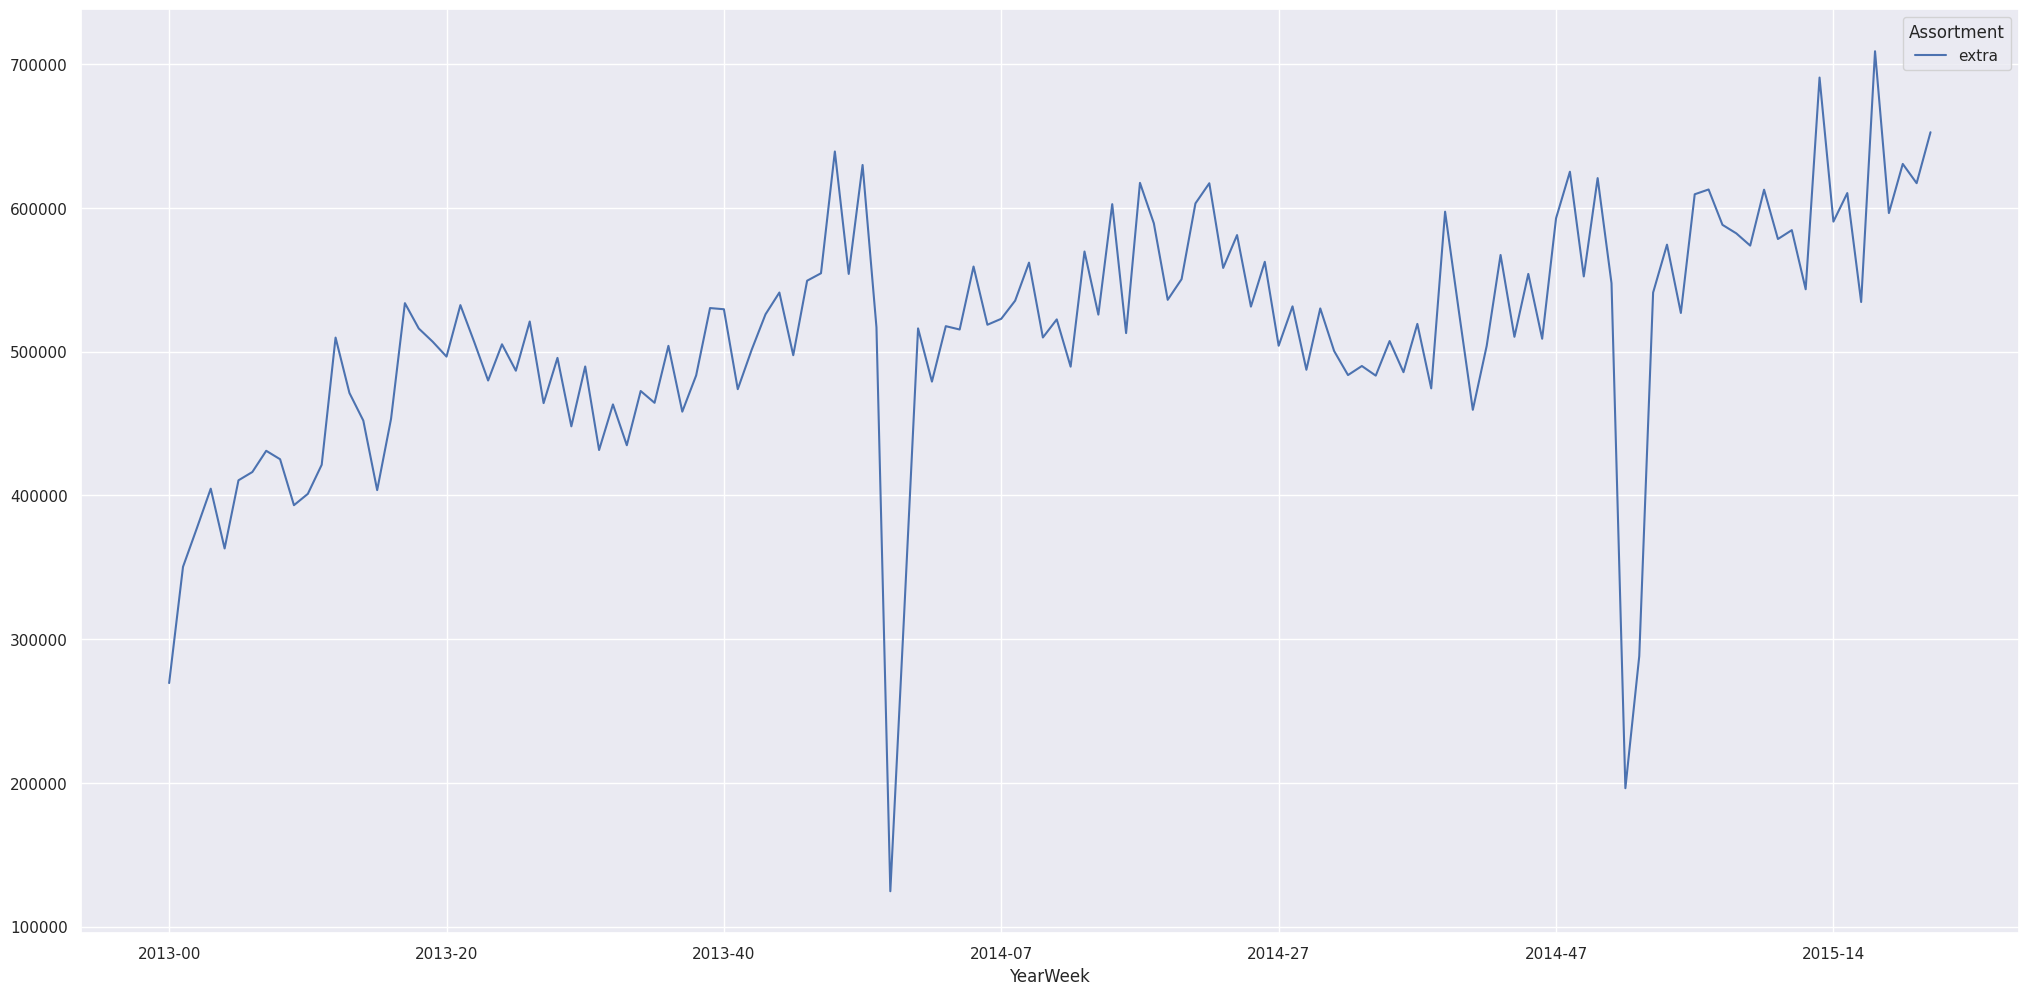

In [35]:
#Comportamento ao longo do tempo
aux2 = df4[['YearWeek','Assortment','Sales']].groupby(['YearWeek','Assortment']).sum().reset_index()
aux2.pivot(index = 'YearWeek',columns='Assortment',values='Sales').plot()

aux3 = aux2[aux2['Assortment']=='extra']
aux3.pivot(index = 'YearWeek',columns='Assortment',values='Sales').plot()

##### VENDAS x DISTÂNCIA DO COMPETIDOR

In [36]:
df4['CompetitionDistance'].agg(["mean","median","std","min","max","skew","kurtosis"])

mean          5702.875324
median        2330.000000
std           9158.193983
min             20.000000
max         100000.000000
skew             4.600909
kurtosis        34.480618
Name: CompetitionDistance, dtype: float64

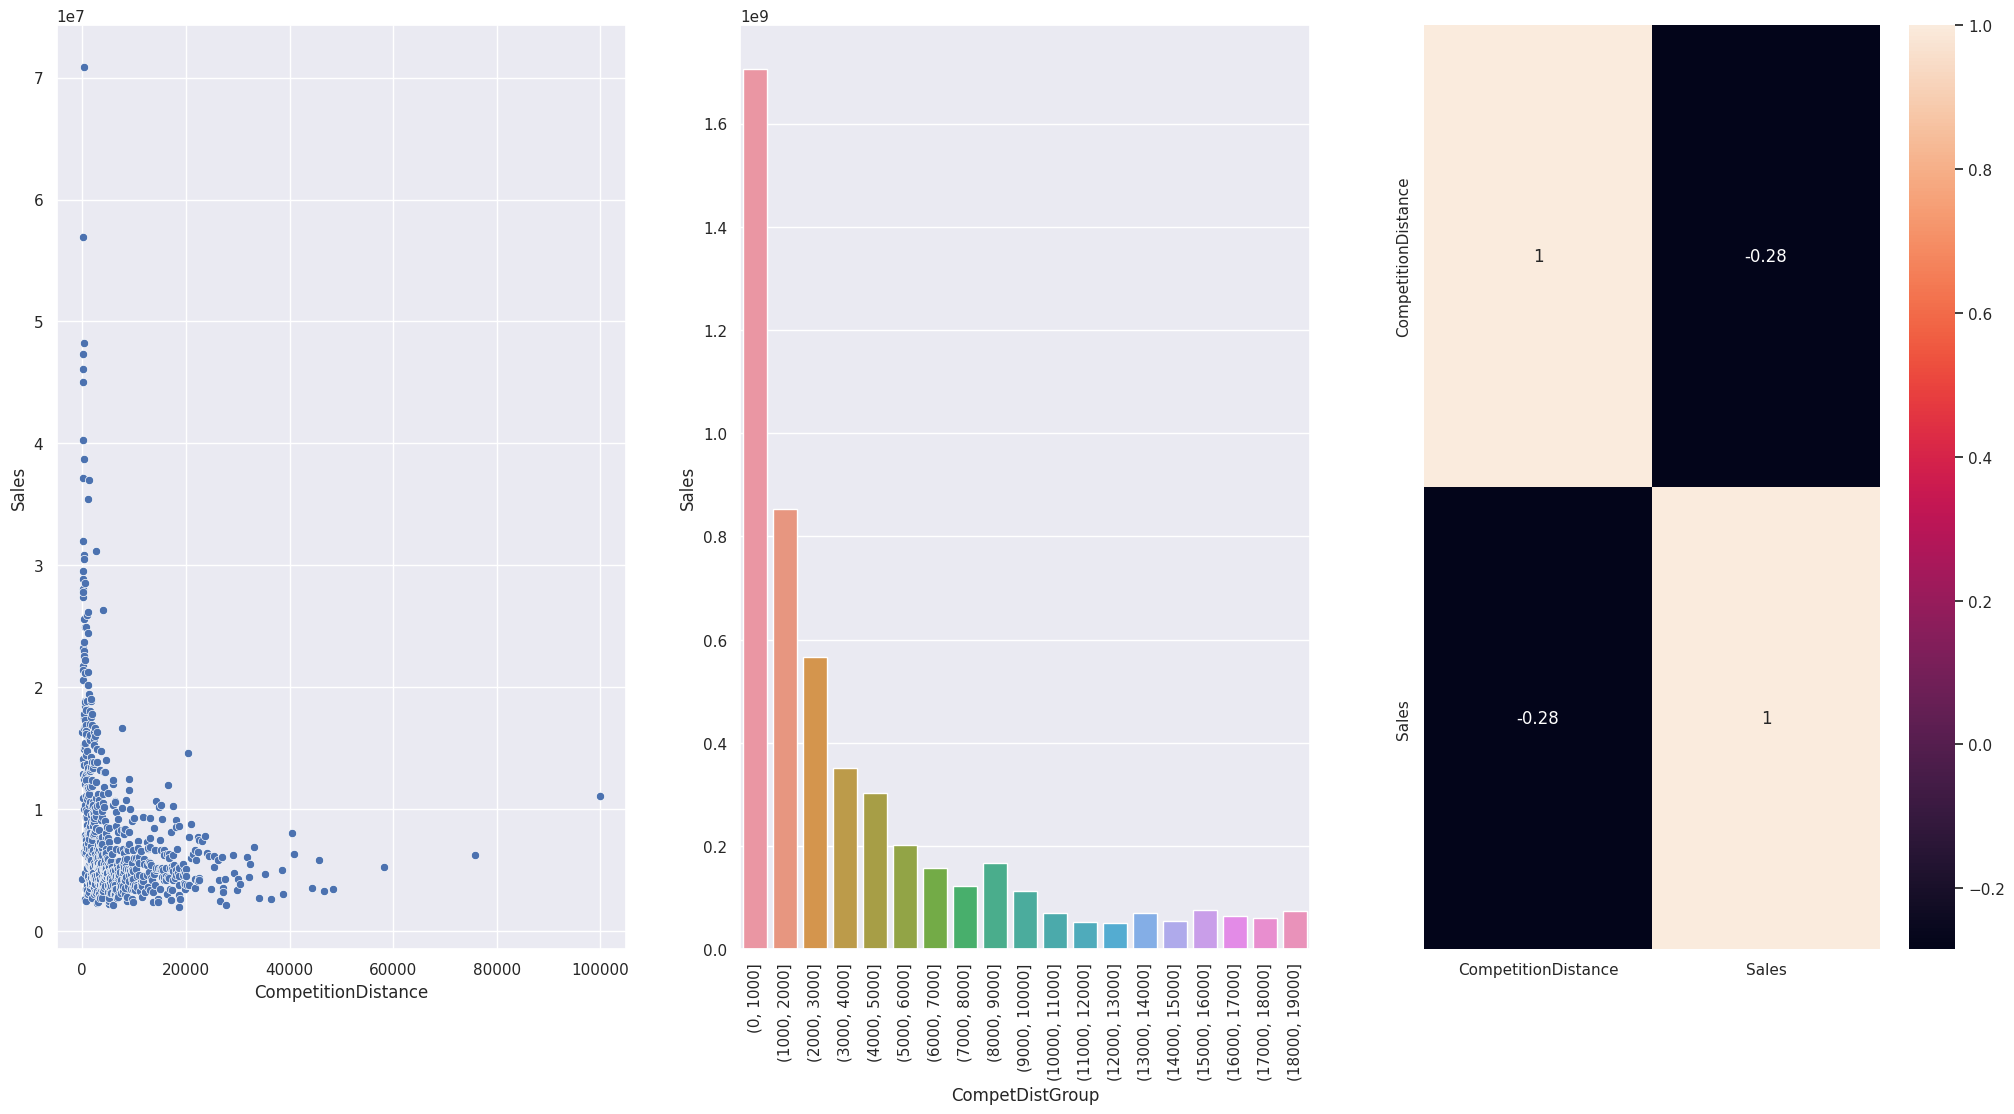

In [37]:
aux1 = df4[['CompetitionDistance','Sales']].groupby('CompetitionDistance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot(x='CompetitionDistance', y='Sales', data = aux1)

plt.subplot( 1, 3, 2 )
groups = list( np.arange( 0, 20000, 1000) )
#adicionar a aux1 os valores de distancia categorizados por grupos
aux1['CompetDistGroup'] = pd.cut(aux1['CompetitionDistance'],bins=groups)
aux2 = aux1[['CompetDistGroup','Sales']].groupby('CompetDistGroup').sum().reset_index()
sns.barplot(x = 'CompetDistGroup', y='Sales',data = aux2);
plt.xticks(rotation = 90);

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

##### VENDAS x TEMPO COM COMPETIDORES

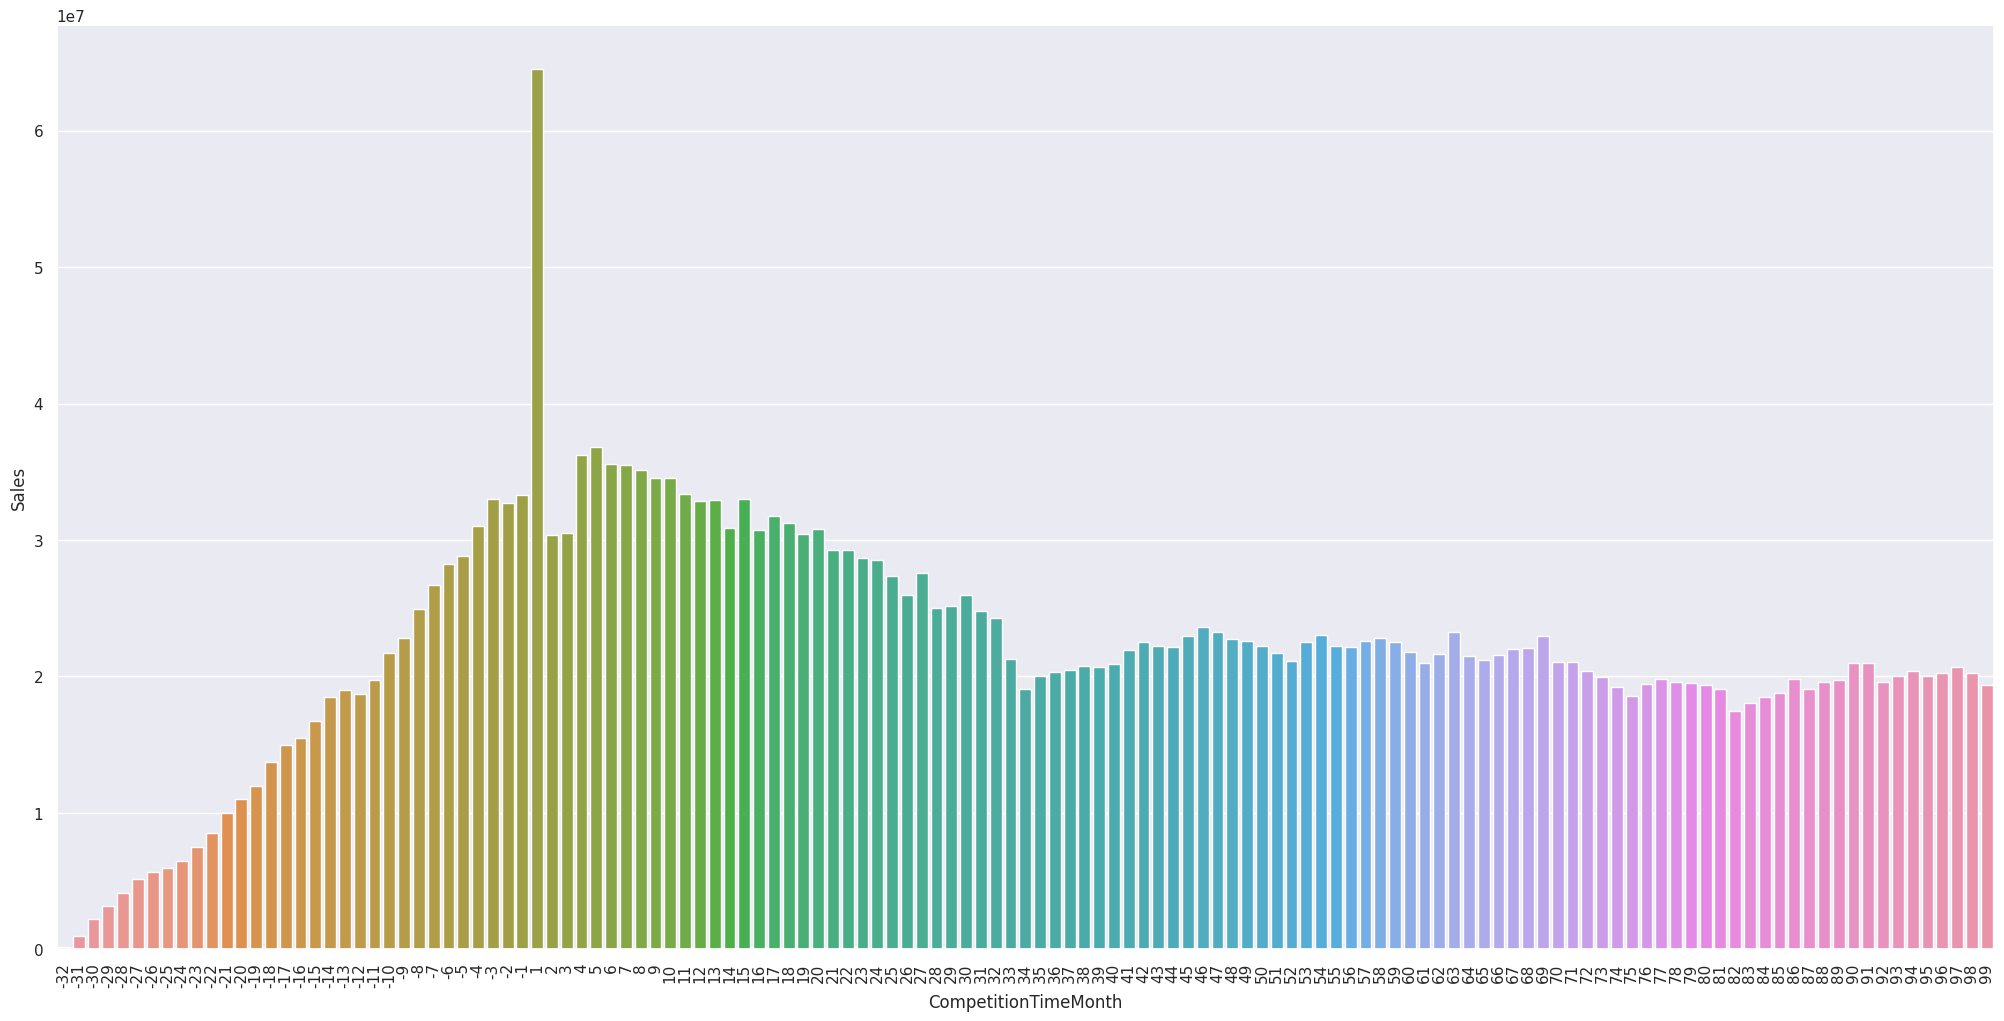

In [38]:
aux1 = df4[['CompetitionTimeMonth', 'Sales']].groupby('CompetitionTimeMonth' ).sum().reset_index()
#vizualização considerando que'CompetitionTimeMonth' -> max = 1405, mean = 40.9, median = 15, skew = 7.37
aux2 = aux1[( aux1['CompetitionTimeMonth'] < 100 ) & (aux1['CompetitionTimeMonth'] != 0 )]
sns.barplot( x='CompetitionTimeMonth', y='Sales', data=aux2 );
plt.xticks( rotation=90 );

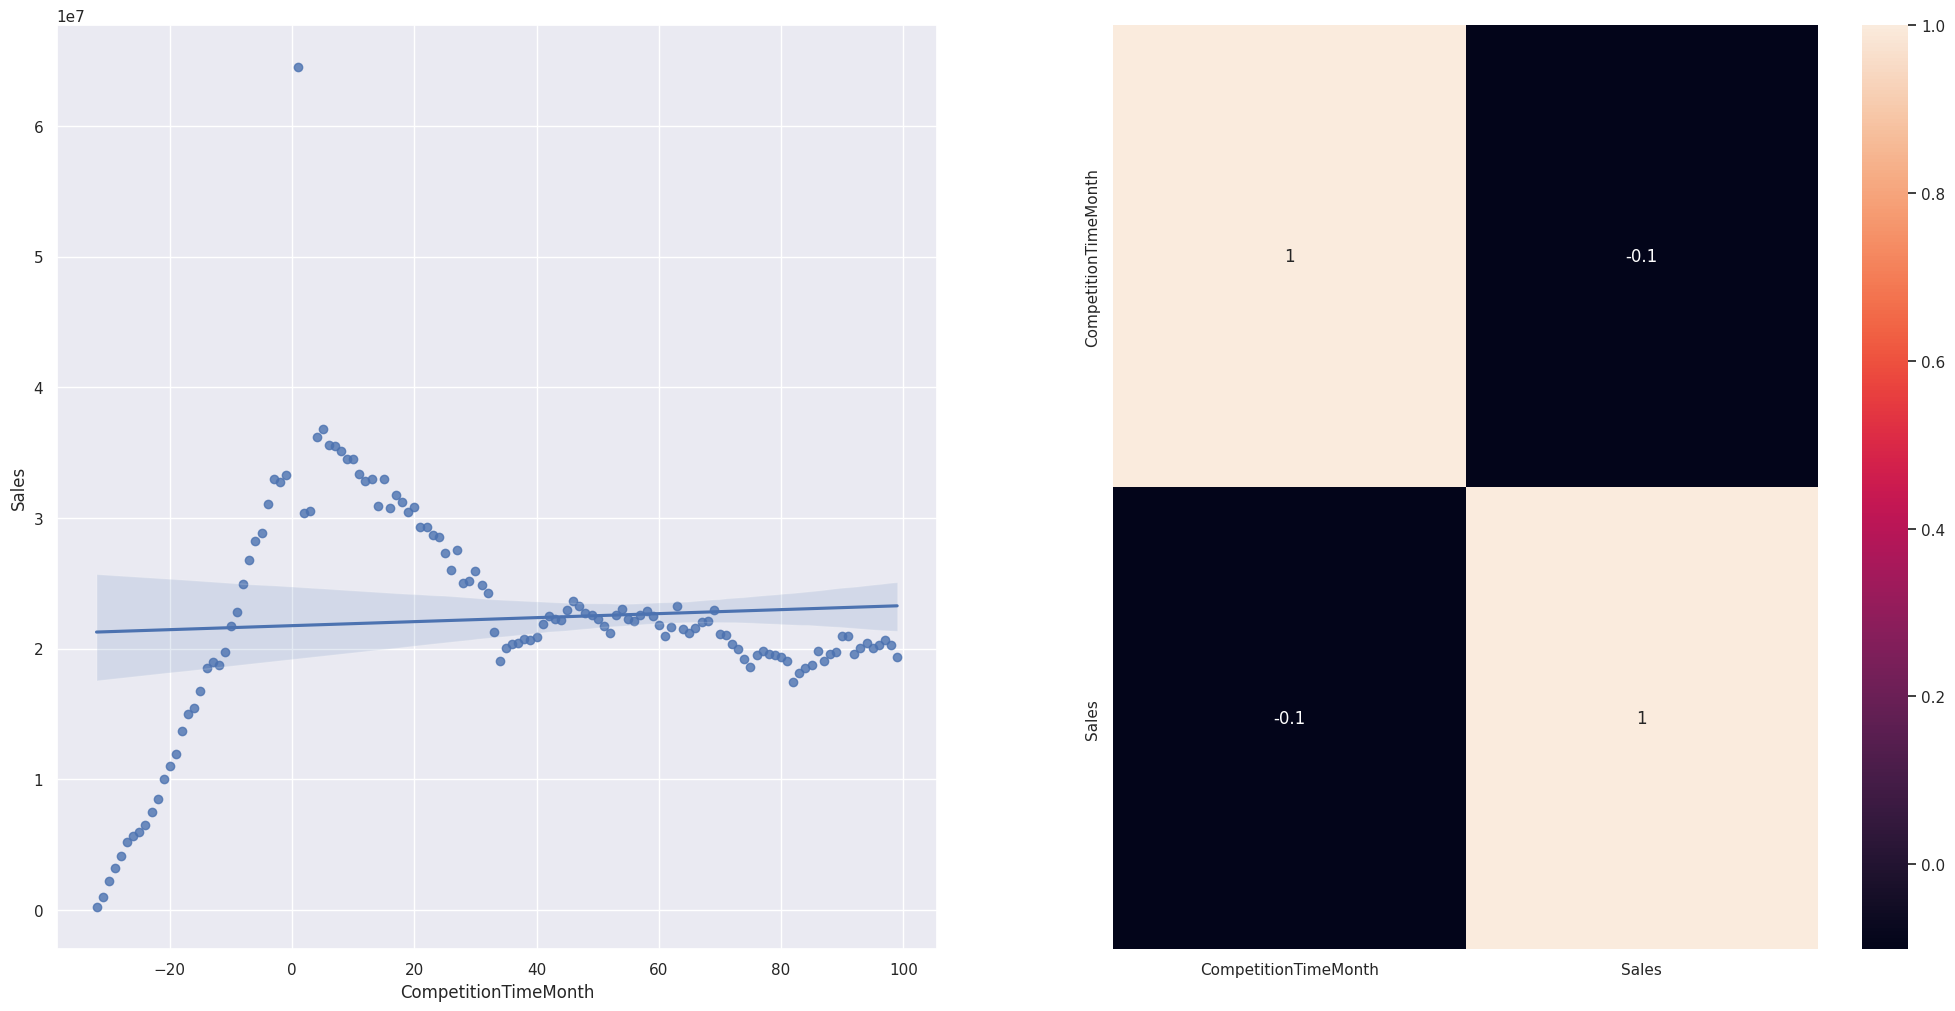

In [39]:
plt.subplot( 1, 2, 1 )
#por se tratar de dados com comportamento não linear, usar apenas para ter noção da tendência
sns.regplot( x='CompetitionTimeMonth', y='Sales', data=aux2 );

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

##### VENDAS x PROMOÇÕES

In [40]:
#relação do volume de vendas das lojas que perticiparam dos períodos promocionais
df4[['Promo', 'Promo2', 'Sales']].groupby( ['Promo', 'Promo2'] ).sum().reset_index()

,Promo,Promo2,Sales
0,0,0,1385060979
1,0,1,1200220926
2,1,0,1509201110
3,1,1,1359011619


##### VENDAS x FERIADOS

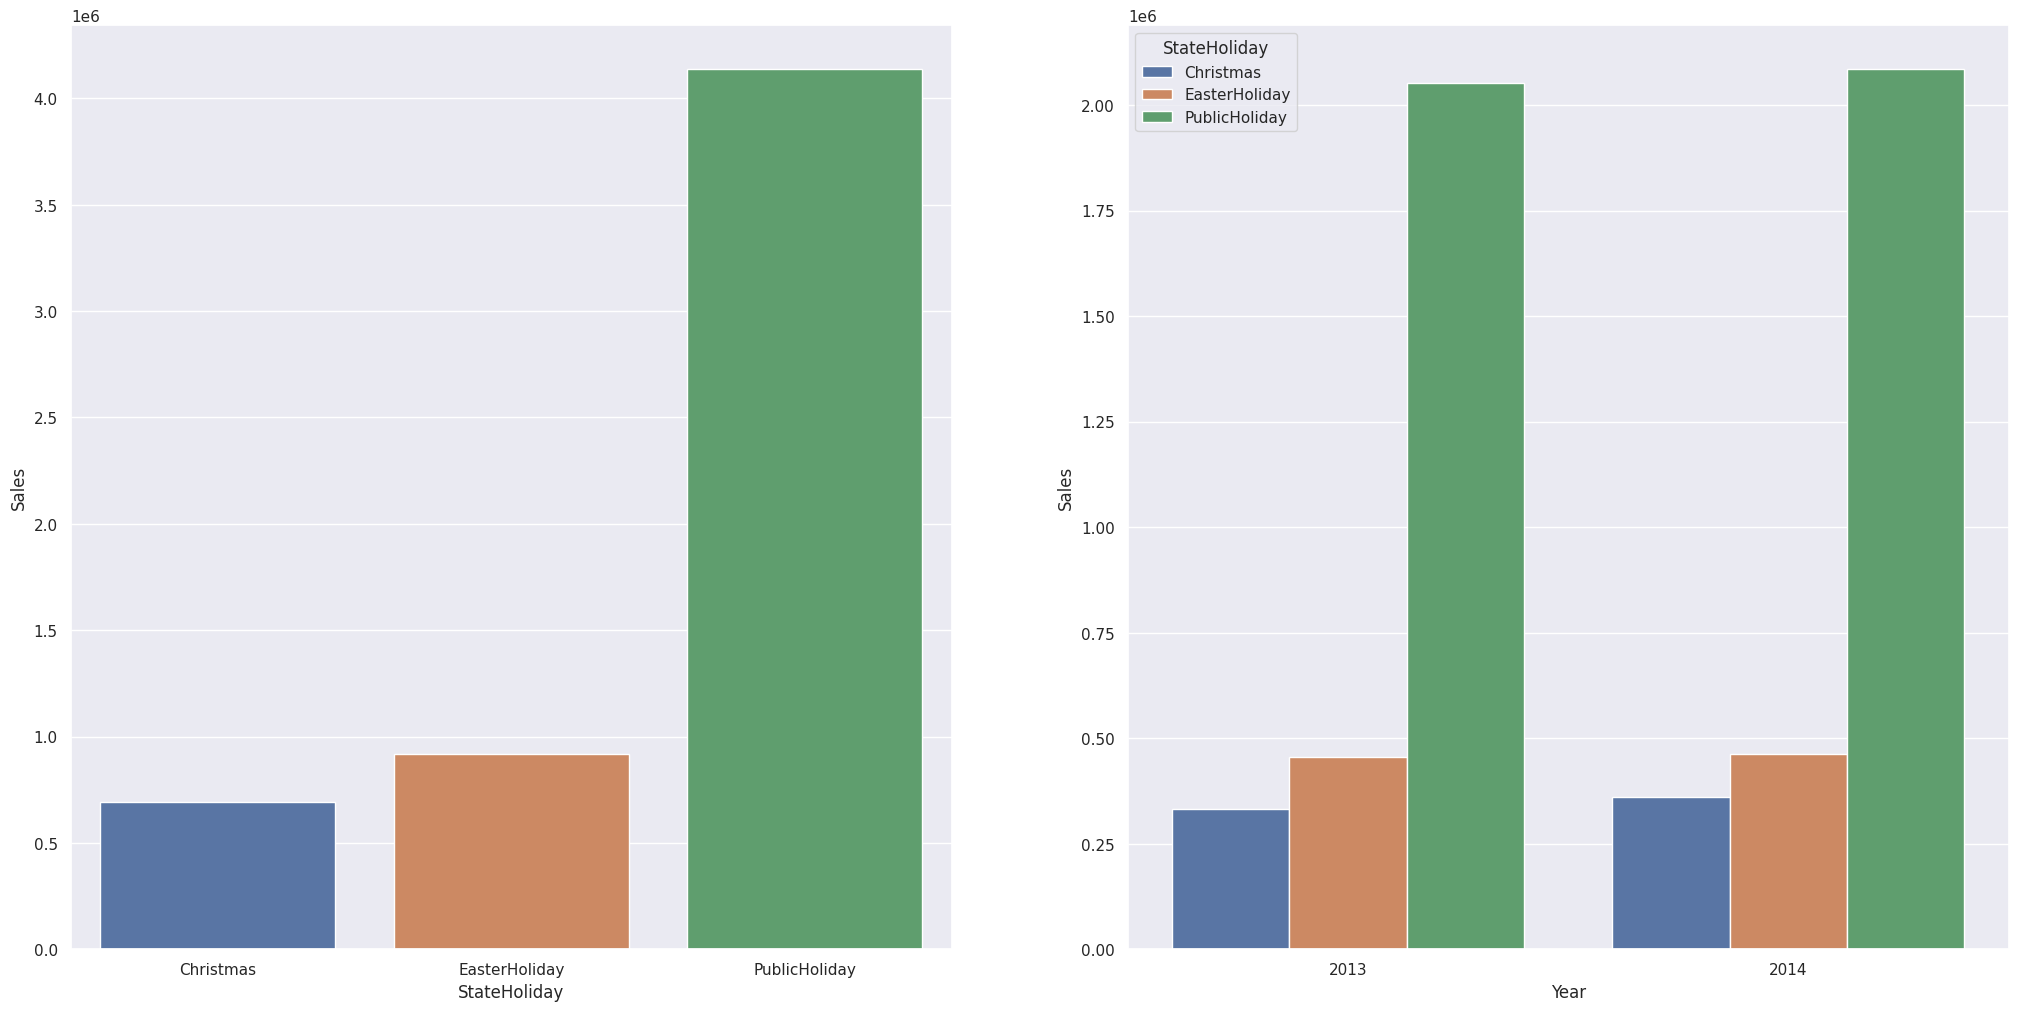

In [41]:
#filtrando feriados e anos completos(visto que a data mais recente(2015-05-31) não tem as vendas de natal do ano de 2015 ainda)
#data mais antiga: 2013-01-01
aux = df4[(df4['StateHoliday'] != 'RegularDay') & (df4['Year'] < 2015)]
plt.subplot( 1, 2, 1 )
aux1 = aux[['StateHoliday', 'Sales']].groupby( 'StateHoliday' ).sum().reset_index()

sns.barplot( x='StateHoliday', y='Sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['Year', 'StateHoliday', 'Sales']].groupby( ['Year','StateHoliday'] ).sum().reset_index()
sns.barplot( x='Year', y='Sales', hue='StateHoliday', data=aux2 );

##### VENDAS x ANOS

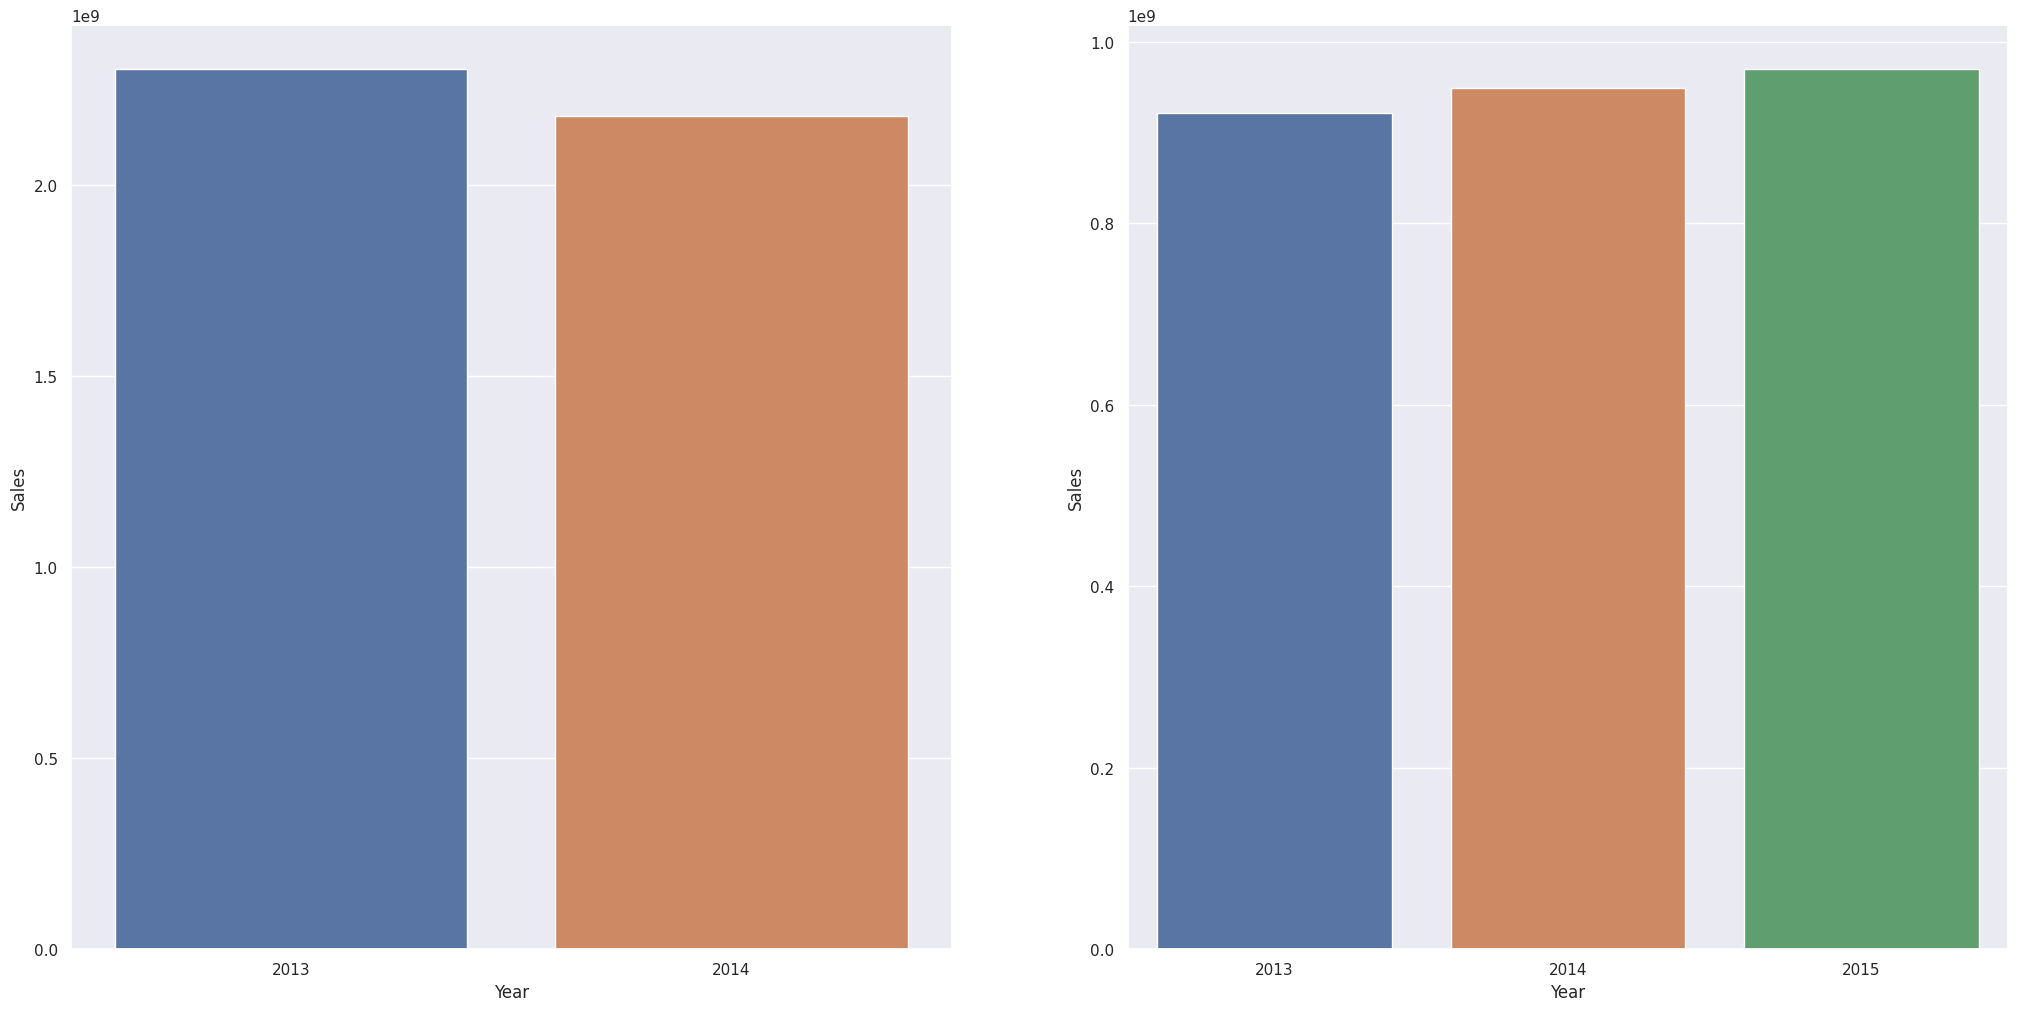

In [42]:
aux1 = df4[(df4['Year']<2015)]
aux1 = aux1[['Year', 'Sales']].groupby('Year').sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='Year', y='Sales', data=aux1 );

#primeiros 5 meses completos, considerando que a data mais recente é 31 de maio de 2015
aux2 = df4[(df4['Month']<6)]
aux2 = aux2[['Year', 'Sales']].groupby('Year').sum().reset_index()
plt.subplot( 1, 2, 2 )
sns.barplot( x='Year', y='Sales', data=aux2 );

##### VENDAS x MESES

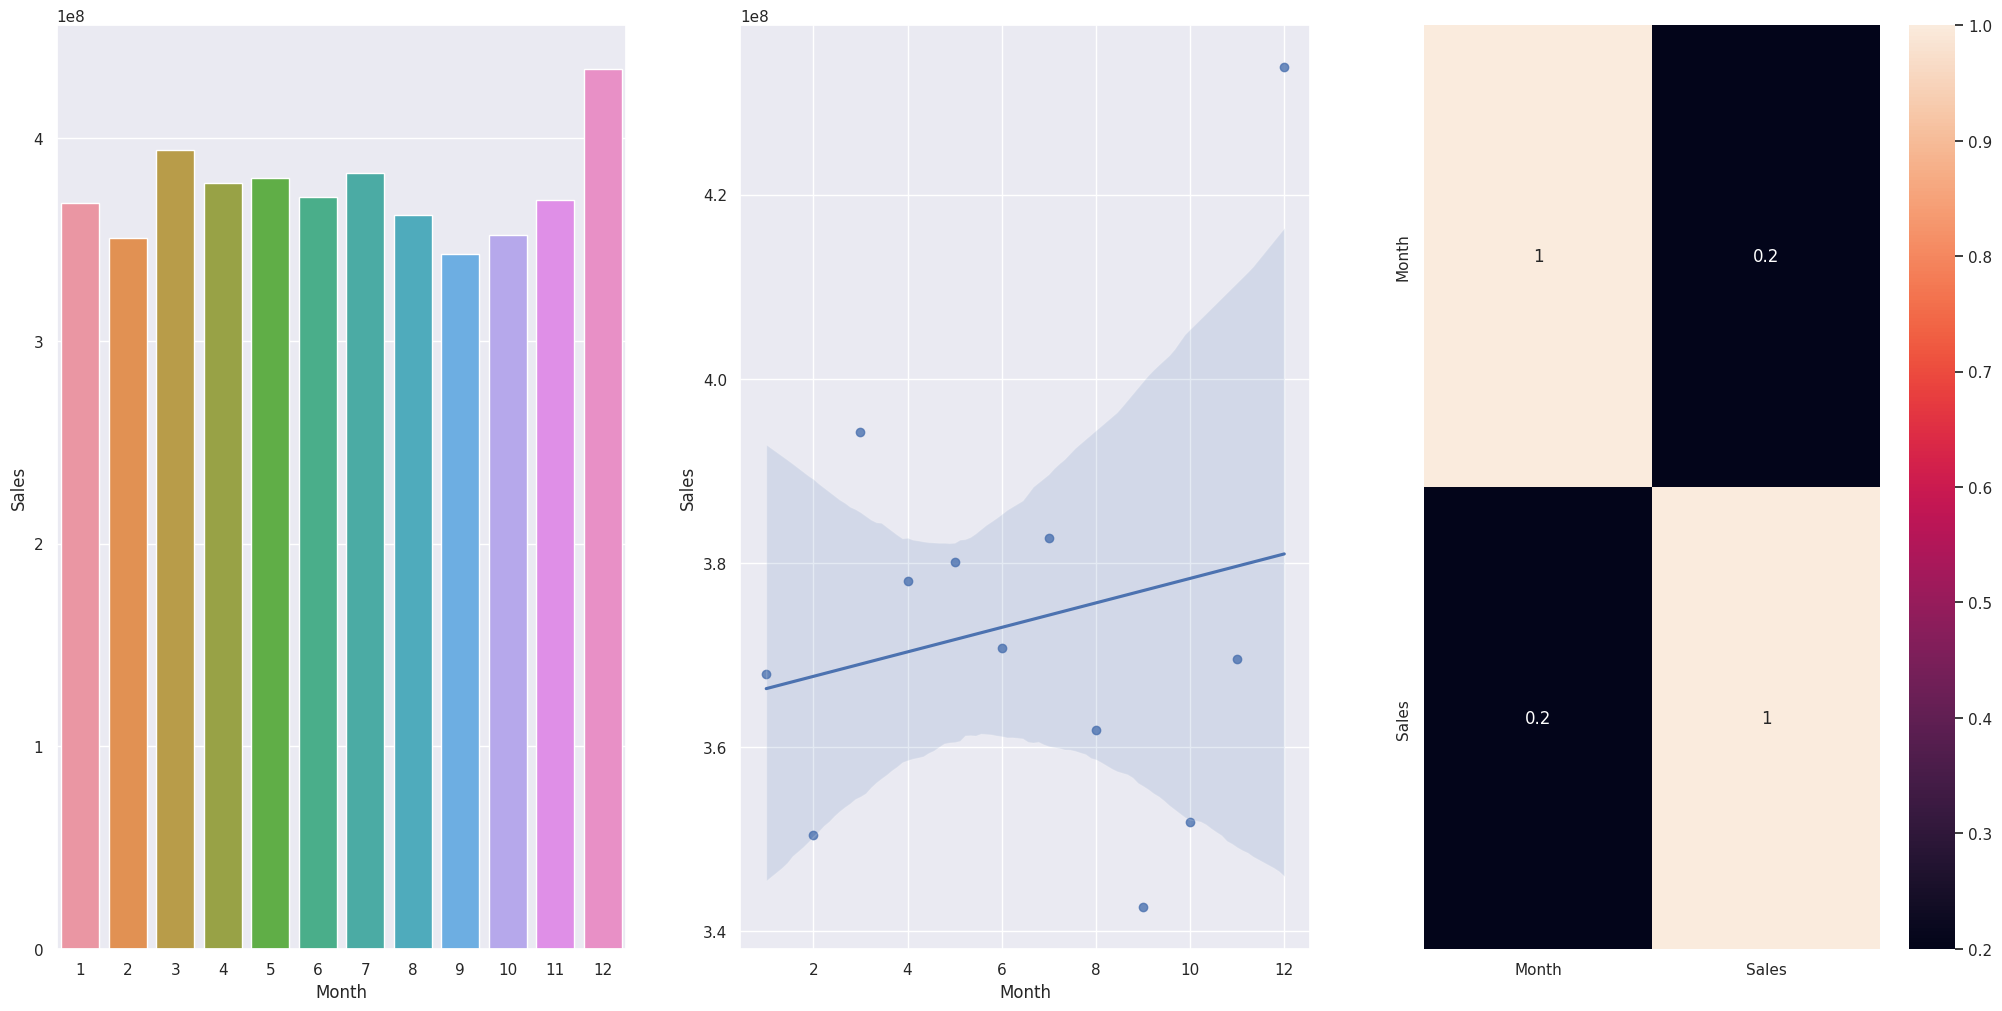

In [43]:
#filtro para anos completos

aux1 = df4[(df4['Year']<2015)]
aux1 = aux1[['Month', 'Sales']].groupby('Month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='Month', y='Sales', data=aux1 );

plt.subplot(1,3,2)
sns.regplot( x='Month', y='Sales', data=aux1 );

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

##### VENDAS x DIAS DA SEMANA

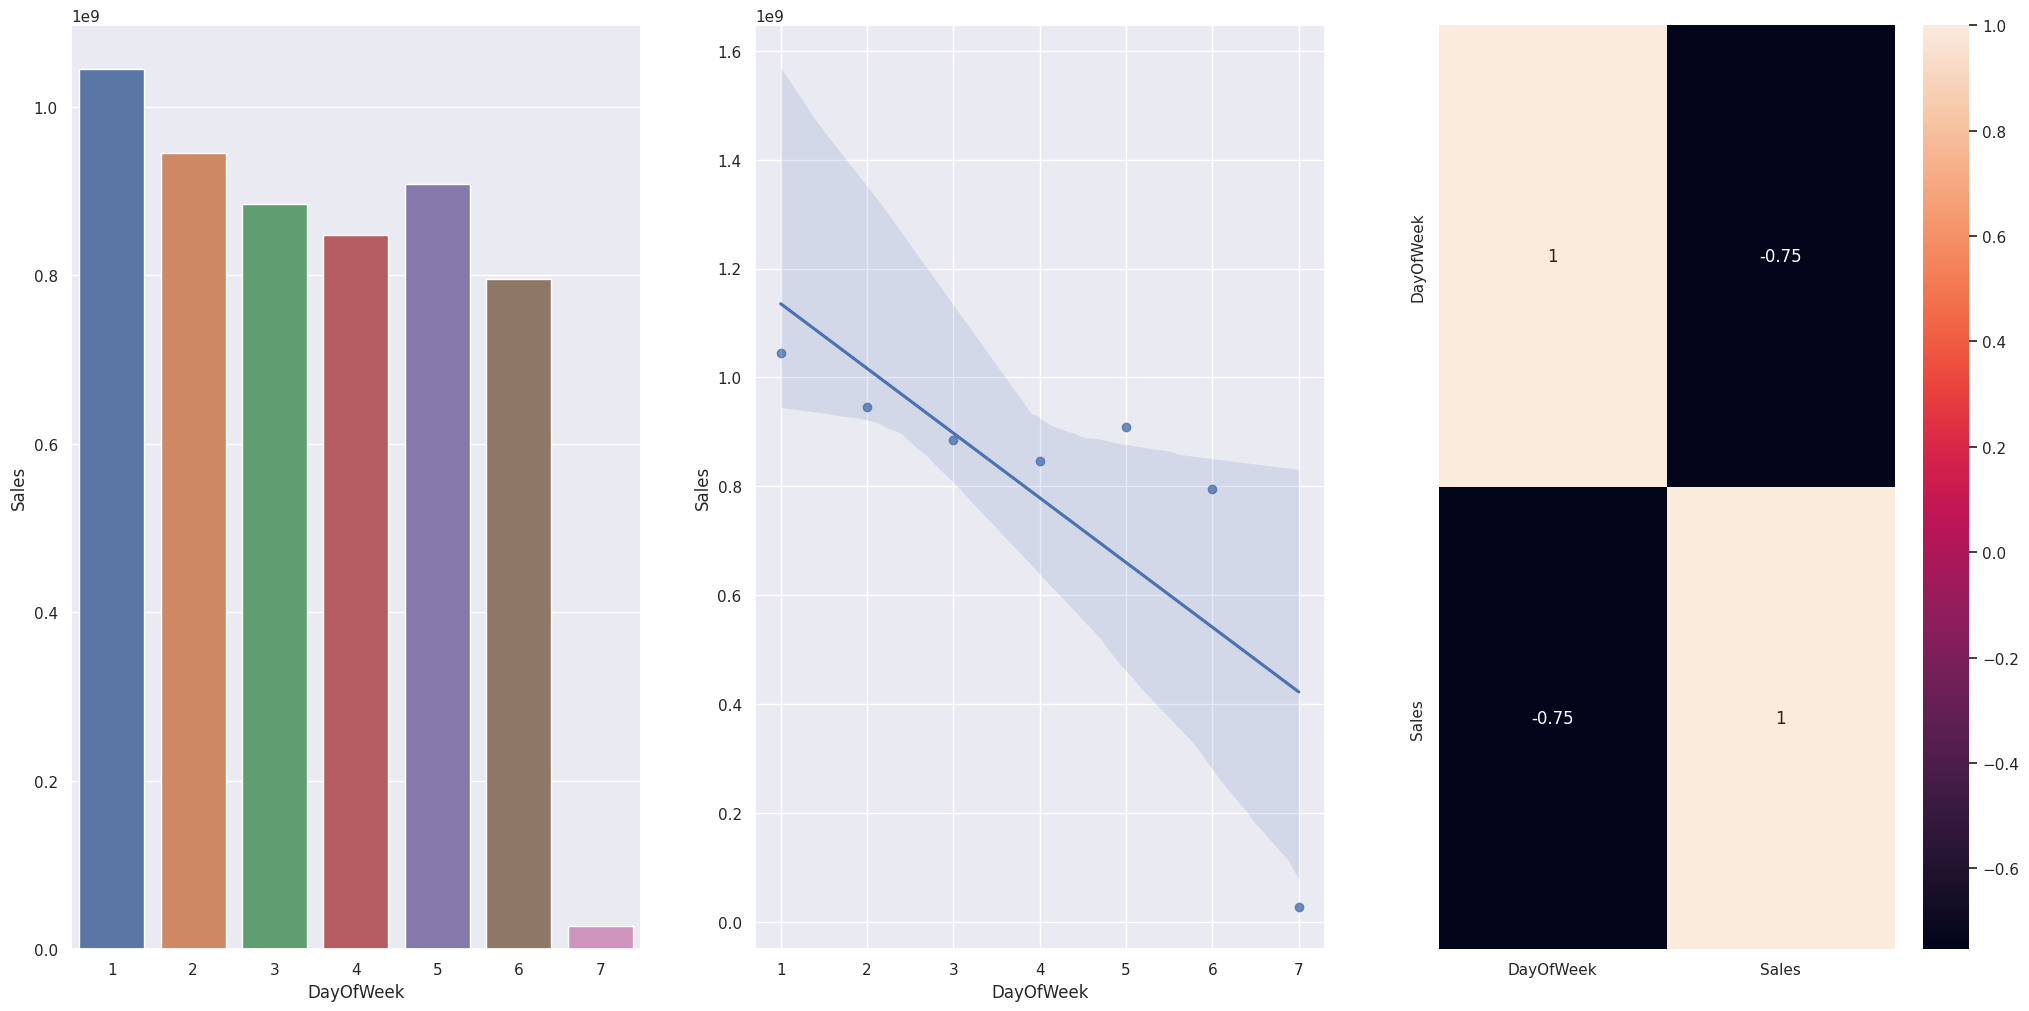

In [44]:
aux1 = df4[['DayOfWeek', 'Sales']].groupby('DayOfWeek').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='DayOfWeek', y='Sales', data=aux1 );

plt.subplot(1,3,2)
sns.regplot( x='DayOfWeek', y='Sales', data=aux1 );

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### ANÁLISE MULTIVARIADA

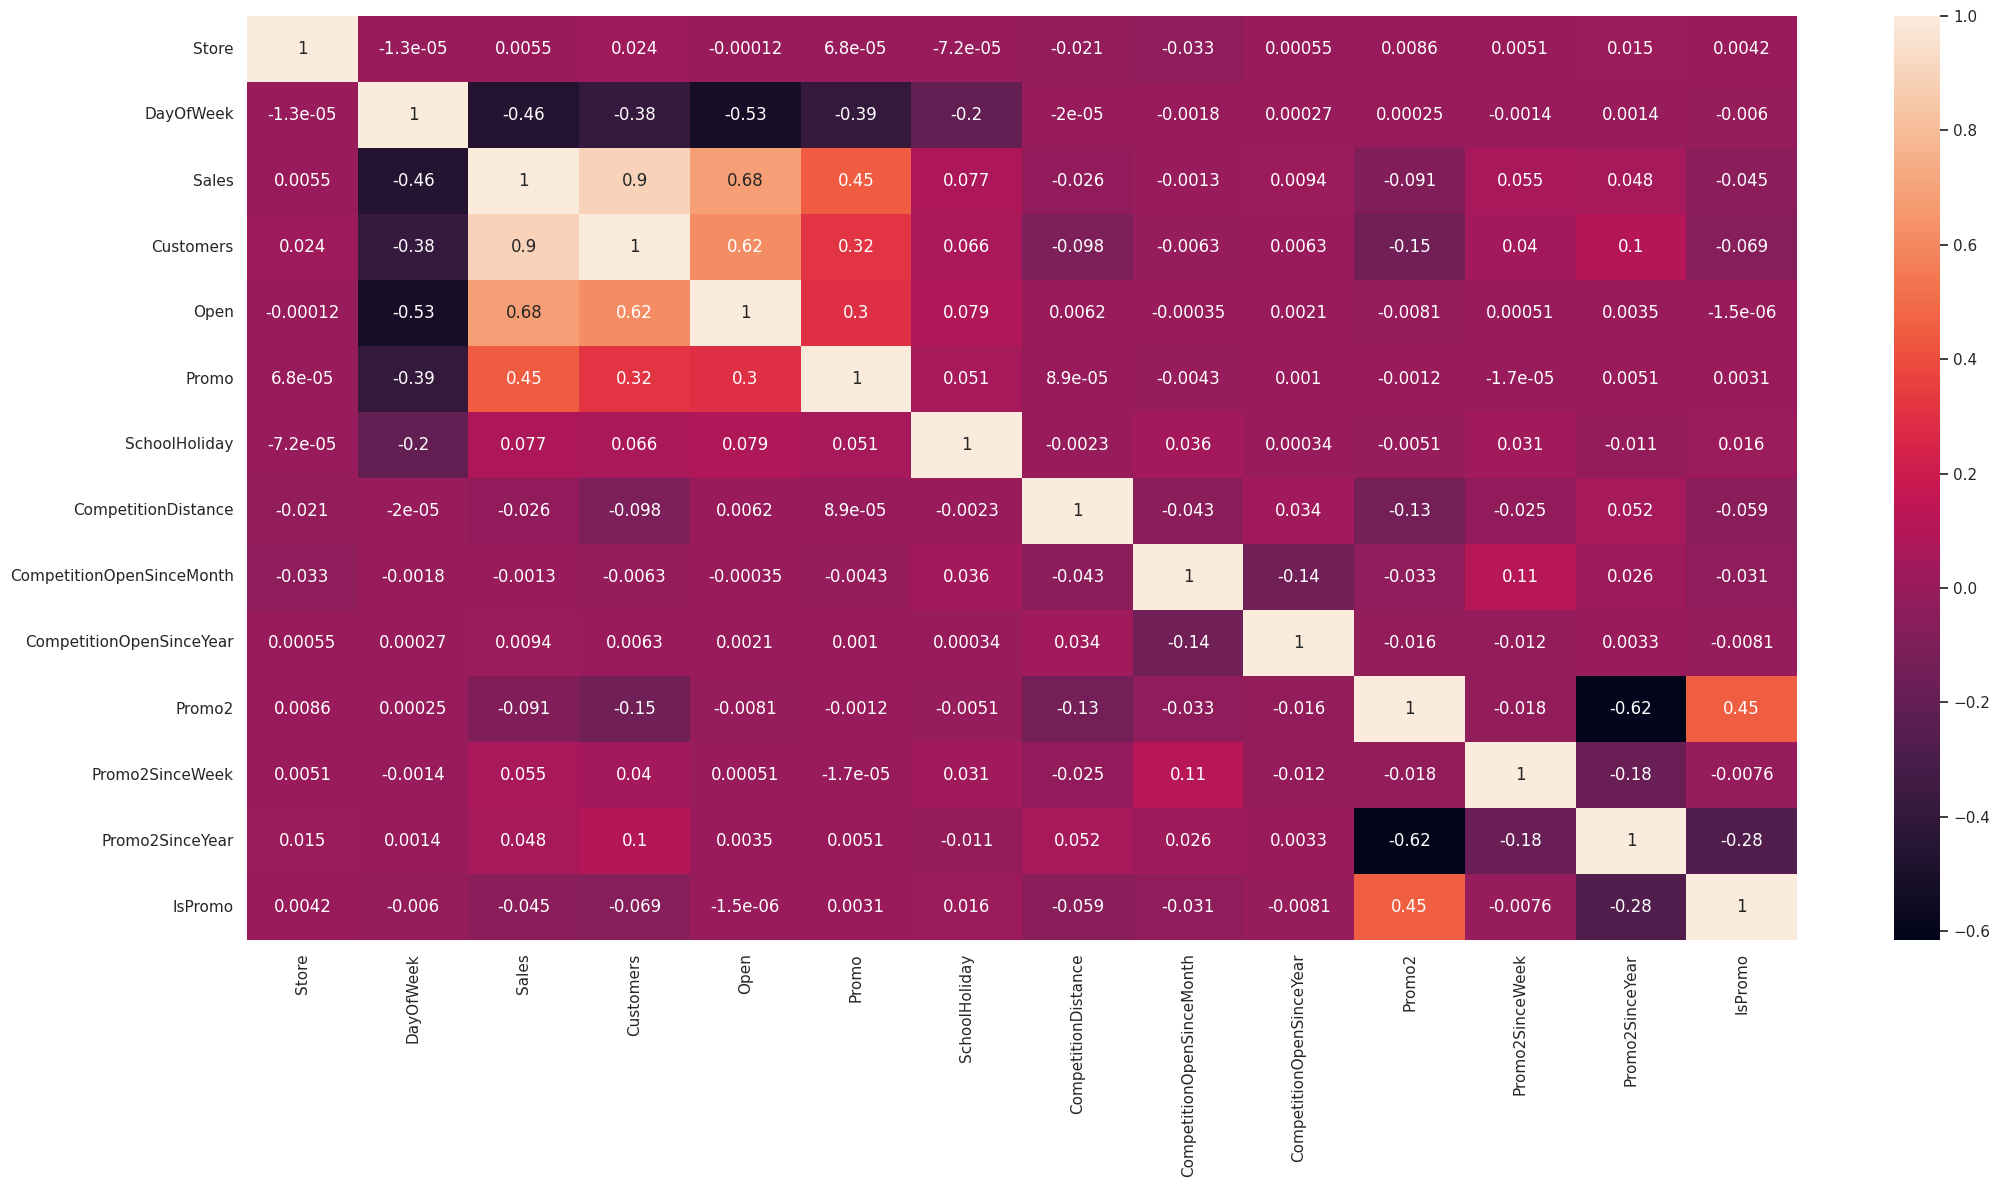

In [45]:
#matriz de correlação para variáveis numéricas
correlation = numAtt.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

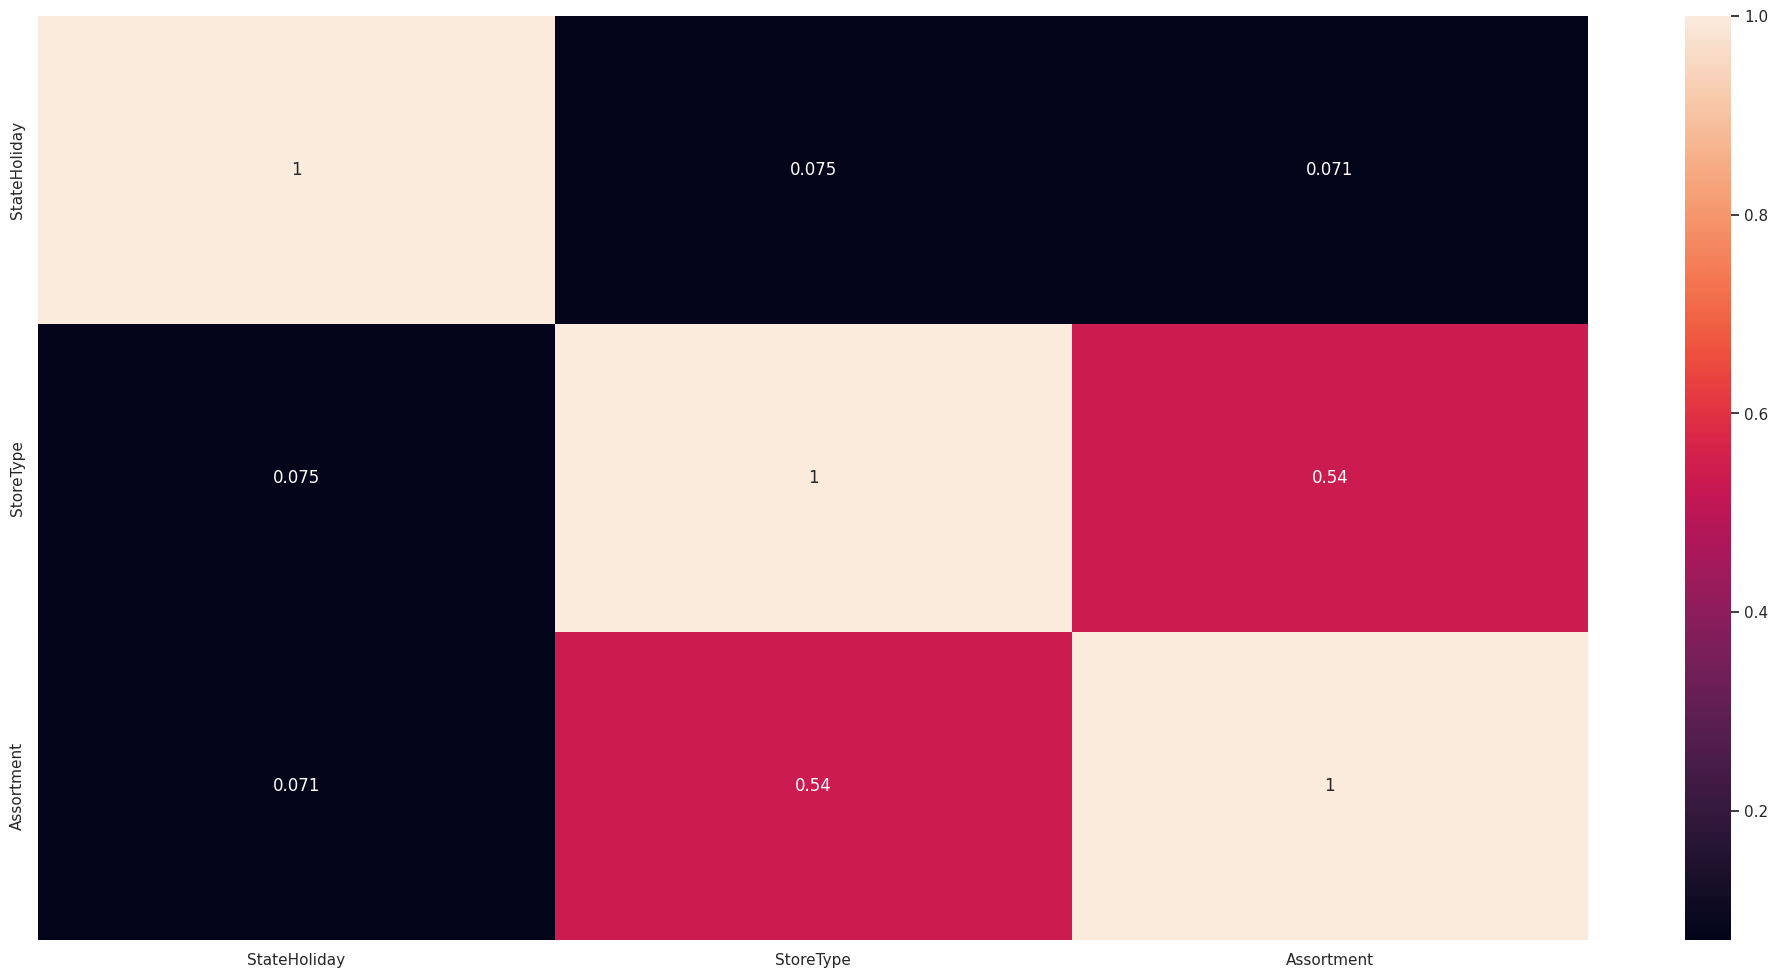

In [46]:
#cramer v (método de correlação para variáveis categóricas)

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values#crosstab gera uma tabela de contagem de correspondencia entre as features de entrada
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]#parametro chi quadrado calculado pelo método chi2_contingency da biblioteca stats do scipy
    #correção do bias dos parâmetros
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['StateHoliday'], a['StateHoliday'] )
a2 = cramer_v( a['StateHoliday'], a['StoreType'] )
a3 = cramer_v( a['StateHoliday'], a['Assortment'] )
a4 = cramer_v( a['StoreType'], a['StateHoliday'] )
a5 = cramer_v( a['StoreType'], a['StoreType'] )
a6 = cramer_v( a['StoreType'], a['Assortment'] )
a7 = cramer_v( a['Assortment'], a['StateHoliday'] )
a8 = cramer_v( a['Assortment'], a['StoreType'] )
a9 = cramer_v( a['Assortment'], a['Assortment'] )
# Final dataset
d = pd.DataFrame( {'StateHoliday': [a1, a2, a3],
'StoreType': [a4, a5, a6],
'Assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# PREPARAÇÃO DOS DADOS

### RESCALING

In [47]:
df5 = df4.copy()

In [48]:
#bilbioteca sklearn
rs = RobustScaler()

#rescaling de variáveis numéricas com robust scaler
#exportar o modelo com pickle
df5['CompetitionDistance'] = rs.fit_transform( df5[['CompetitionDistance']].values)
pickle.dump( rs, open( '/home/aroldo/repos/dsprod/parameter/competition_distance_scaler.pkl', 'wb') )

df5['CompetitionTimeMonth'] = rs.fit_transform( df5[['CompetitionTimeMonth']].values)
pickle.dump( rs, open( '/home/aroldo/repos/dsprod/parameter/competition_time_month_scaler.pkl', 'wb') )

df5['Promo2TimeWeek'] = rs.fit_transform( df5[['Promo2TimeWeek']].values)
pickle.dump( rs, open( '/home/aroldo/repos/dsprod/parameter/promo_time_week_scaler.pkl', 'wb') )

df5['Year'] = rs.fit_transform( df5[['Year']].values)
pickle.dump( rs, open( '/home/aroldo/repos/dsprod/parameter/year_scaler.pkl', 'wb') )

### TRANFORMAÇÃO DE VARIÁVEIS

In [49]:
#Encoding de variáveis categóricas
#one hot encoding
df5 = pd.get_dummies( df5, prefix=['StateHol'], columns=['StateHoliday'] )

#label encoding de store type(a,b,c,d para 0,1,2,3)
le = LabelEncoder()
df5['StoreType'] = le.fit_transform( df5['StoreType'] )
#exportar o modelo com pickle
pickle.dump( le, open( '/home/aroldo/repos/dsprod/parameter/store_type_scaler.pkl', 'wb') )

#ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['Assortment'] = df5['Assortment'].map( assortment_dict )

In [50]:
#transformação de grandeza da variável resposta
df5['Sales'] = np.log1p( df5['Sales'] )

In [51]:
#tranformação de natureza

# day of week
df5['DayOfWeekSin'] = df5['DayOfWeek'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['DayOfWeekCos'] = df5['DayOfWeek'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['MonthSin'] = df5['Month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['MonthCos'] = df5['Month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['DaySin'] = df5['Day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['DayCos'] = df5['Day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['WeekOfYearSin'] = df5['WeekOfYear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['WeekOfYearCos'] = df5['WeekOfYear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

### FUNÇÃO DATA PREPARATION

In [52]:
def dataPreparation(df):
    rs = RobustScaler()
    df['CompetitionDistance'] = rs.fit_transform( df[['CompetitionDistance']].values)
    df['CompetitionTimeMonth'] = rs.fit_transform( df[['CompetitionTimeMonth']].values)
    df['Promo2TimeWeek'] = rs.fit_transform( df[['Promo2TimeWeek']].values)
    df['Year'] = rs.fit_transform( df[['Year']].values)
    df = pd.get_dummies( df, prefix=['StateHol'], columns=['StateHoliday'] )
    le = LabelEncoder()
    df['StoreType'] = le.fit_transform( df['StoreType'] )
    assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
    df['Assortment'] = df['Assortment'].map( assortment_dict )
    df['Sales'] = np.log1p( df['Sales'] )
    df['DayOfWeekSin'] = df['DayOfWeek'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
    df['DayOfWeekCos'] = df['DayOfWeek'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
    df['MonthSin'] = df['Month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
    df['MonthCos'] = df['Month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
    df['DaySin'] = df['Day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
    df['DayCos'] = df['Day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
    df['WeekOfYearSin'] = df['WeekOfYear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
    df['WeekOfYearCos'] = df['WeekOfYear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
    cols_drop = ['WeekOfYear', 'Day', 'Month', 'DayOfWeek', 'Promo2Since', 'CompetitionSince', 'YearWeek' ]
    df = df.drop( cols_drop, axis=1 )
    return df

# FEATURE SELECTION

In [53]:
df6 = df5.copy()

### LIMPEZA DAS FEATURES JÁ ENCODADAS E TRANSFORMADAS

In [54]:
cols_drop = ['WeekOfYear', 'Day', 'Month', 'DayOfWeek', 'Promo2Since', 'CompetitionSince', 'YearWeek' ]
df6 = df6.drop( cols_drop, axis=1 )

### PREPARAÇÃO DOS DADOS TESTE

In [55]:
#dataset dos 2 meses recentes separados no começo para evitar contaminação dos dados de treino
dfTest = dataClean(dfTest)
dfTest = featureEng(dfTest)
dfTest = dataPreparation(dfTest)

### SPLIT DOS DADOS TREINO/TESTE

In [56]:
X_train = df6.copy()
y_train = X_train['Sales']

X_test = dfTest.copy()
y_test = X_test['Sales']

print( 'Training Min Date: {}'.format( X_train['Date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['Date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['Date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['Date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-05-31 00:00:00

Test Min Date: 2015-06-01 00:00:00
Test Max Date: 2015-07-31 00:00:00


### BORUTA FEATURE SELECTOR

In [57]:
# #tirar os dados de treino(data e vendas)
# #tirar pois são features que precisam ser escolhidas por se tratar de vendas ao longo do tempo
# X_train_n = X_train.drop( ['Date', 'Sales'], axis=1 ).values
# #transformar em um vetor único com metodo ravel(numpy)
# y_train_n = y_train.values.ravel()

# #random forest, n_jobs=-1 para usar todos os cores  da maquina e executar mais rápido
# rf = RandomForestRegressor(n_jobs=-2)

# #boruta usando random forest
# #deixar automatico a escolha de melhores árvores para ramificação
# #verbose para feedback da execução
# #random_state para fixar a seed randomica
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=123 ).fit( X_train_n, y_train_n )

In [58]:
# #lista de true e false das variáveis consideradas relevantes
# cols_selected = boruta.support_.tolist()

# #dropar de novo as variaveis de treino em um novo df X_train_fs
# X_train_fs = X_train.drop( ['Date', 'Sales'], axis=1 )

# #de todas as colunas selecionar os que forem true da lista cols_selected
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #selecionar as features que não foram escolhidas pela diferença das arrays
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [59]:
# cols_selected_boruta
# ['Store',
#  'Promo',
#  'StoreType',
#  'Assortment',
#  'CompetitionDistance',
#  'CompetitionOpenSinceMonth',
#  'CompetitionOpenSinceYear',
#  'Promo2',
#  'Promo2SinceWeek',
#  'Promo2SinceYear',
#  'CompetitionTimeMonth',
#  'Promo2TimeWeek',
#  'DayOfWeekSin',
#  'DayOfWeekCos',
#  'MonthCos',
#  'DaySin',
#  'DayCos',
#  'WeekOfYearCos']

In [60]:
# cols_not_selected_boruta
# ['IsPromo',
#  'MonthSin',
#  'SchoolHoliday',
#  'StateHol_Christmas',
#  'StateHol_EasterHoliday',
#  'StateHol_PublicHoliday',
#  'StateHol_RegularDay',
#  'WeekOfYearSin',
#  'Year']

In [61]:
#ajuste manual das features relevantes escolhidas pelo boruta
#adicionar MonthSin WeekOfYearSin embora o boruta tenha julgado nao relevante
#escolha pois tratam-se de uma unica variável Month e WeekOfYear com transformação de natureza
cols_selected_boruta = [ 'Store',
                         'Promo',
                         'StoreType',
                         'Assortment',
                         'CompetitionDistance',
                         'CompetitionOpenSinceMonth',
                         'CompetitionOpenSinceYear',
                         'Promo2',
                         'Promo2SinceWeek',
                         'Promo2SinceYear',
                         'CompetitionTimeMonth',
                         'Promo2TimeWeek',
                         'DayOfWeekSin',
                         'DayOfWeekCos',
                         'MonthCos',
                         'DaySin',
                         'DayCos',
                         'WeekOfYearCos']
#adicionar de volta as features para treino retiradas 
feat_to_add = ['Date', 'Sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# ML MODELLING

In [62]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
#colunas com datas e vendas para a aplicação do kfold da validação cruzada em serie temporal
x_training = X_train[ cols_selected_boruta_full ]

#função para mensuração e output dos erros calculados pelos modelos de ML
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

#função cross-validation para série temporal
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    #reversed para o k*8*7 do validation_start_date começar da parte recente do dataset
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        #começo e fim da fatia de validação
        #o range de 2 meses(8 semanas) mantem o mesmo entre o validation_start_date e o validation_end_date
        validation_start_date = x_training['Date'].max() - datetime.timedelta( days=k*8*7)
        validation_end_date = x_training['Date'].max() - datetime.timedelta( days=(k-1)*8*7)

        #setando as tanges do treino e teste com base na data
        training = x_training[x_training['Date'] < validation_start_date]
        validation = x_training[(x_training['Date'] >= validation_start_date) & (x_training['Date'] <= validation_end_date)]

        #dropar features de treino(variável resposta e variável de referencia já derivada)
        xtraining = training.drop( ['Date', 'Sales'], axis=1 ) 
        #isolar a variável resposta
        ytraining = training['Sales']

        #o mesmo para o dataset de teste
        xvalidation = validation.drop( ['Date', 'Sales'], axis=1 )
        yvalidation = validation['Sales']

        #model é recebido de parametro na função
        m = model.fit( xtraining, ytraining )

        #predizer a variável resposta com as features do dataset de teste
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0])

### AVERAGE MODEL (MODELO DE BASE)

In [63]:
aux1 = x_test.copy()
aux1['Sales'] = y_test.copy()

#média de vendas por loja como predictions no aux2
aux2 = aux1[['Store', 'Sales']].groupby( 'Store' ).mean().reset_index().rename( columns={'Sales': 'Predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='Store' )
yhat_baseline = aux1['Predictions']

#função np.exp1 para voltar a escala da variável resposta que antes estava na escala logarítmica 
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1424.200631,0.212551,1899.507291


### LINEAR REGRESSION MODEL

In [64]:
#regressão linear (função do sklearn)
lr = LinearRegression().fit( x_train, y_train )

#predição(y hat)
yhat_lr = lr.predict( x_test )

lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2156.416933,0.339844,3230.407809


In [65]:
#com cv
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2013.51 +/- 145.1,0.31 +/- 0.01,2854.38 +/- 224.59


### REGULARIZED LINEAR REGRESSION MODEL (LASSO)

In [66]:
#parâmetro alpha multiplica o peso, a fim de restringir o range do peso
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

#predição(y hat)
yhat_lrr = lrr.predict( x_test )

lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1940.055188,0.285026,2817.421701


In [67]:
#com cv
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2038.0 +/- 152.9,0.3 +/- 0.01,2946.29 +/- 242.85


### RANDOM FOREST REGRESSOR

In [68]:
#implementação do random forest (modelos não-lineares)
#n_estimators numero de árvores
#n_jobs=-1 para usar mais recursos da maquina para execução
#random_state para definir uma seed da randomização
#n_estimators quanto mais melhor mas demora mais(fica boa por volta das 2500 a 3000 árvores de decisão)
rf = RandomForestRegressor( n_estimators=100, n_jobs =-1,random_state=123 ).fit( x_train, y_train )

#predição(y hat)
yhat_rf = rf.predict( x_test )

rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,878.427583,0.124665,1283.77368


In [69]:
#com cv
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,790.83 +/- 155.13,0.11 +/- 0.02,1190.65 +/- 223.87


### XGBOOST REGRESSOR

In [70]:
#XGBoost com parâmetros default
model_xgb = xgb.XGBRegressor().fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1030.896301,0.149725,1448.593184


In [71]:
#com cv
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1020.1 +/- 134.01,0.15 +/- 0.02,1456.47 +/- 187.56


### COMPARAÇÃO DE PERFORMANCE DOS MODELOS

##### SINGLE PERFORMANCE

In [74]:
#comparação dos erros dos modelos gerados
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
#ordenar por valor do RMSE
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,878.427583,0.124665,1283.773680
0,XGBoost Regressor,1030.896301,0.149725,1448.593184
0,Average Model,1424.200631,0.212551,1899.507291
0,Linear Regression - Lasso,1940.055188,0.285026,2817.421701
0,Linear Regression,2156.416933,0.339844,3230.407809


##### PERFORMANCE (CROSS-VALIDATION)

In [75]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.to_csv('/home/aroldo/repos/dsprod/data/performanceCV.csv')
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,790.83 +/- 155.13,0.11 +/- 0.02,1190.65 +/- 223.87
0,XGBoost Regressor,1020.1 +/- 134.01,0.15 +/- 0.02,1456.47 +/- 187.56
0,Linear Regression,2013.51 +/- 145.1,0.31 +/- 0.01,2854.38 +/- 224.59
0,Lasso,2038.0 +/- 152.9,0.3 +/- 0.01,2946.29 +/- 242.85


# HYPERPARAMETER FINE TUNING

### RANDOM SEARCH

In [76]:
# #random search para os parâmetros do XGBoost
# # ideal para n_estimators é 1500 a 3500 mas demora muito se não for em servidor
# param = {
#    'n_estimators': [500, 750, 1000, 1250, 1500],#default=100
#    'eta': [0.01, 0.03],#default=0.3
#    'max_depth': [3, 5, 9],#default=6
#    'subsample': [0.1, 0.5, 0.7],#default=1
#    'colsample_bytree': [0.3, 0.7, 0.9],#default=1
#    'min_child_weight': [3, 8, 15]#default=1
#        }

# #numero de iterações para achar os parâmetros aleatoriamente
# numIter = 10

# #criar um dataframe vazio para armazenar os resultados
# final_result = pd.DataFrame()

# for i in range( numIter ):
#    #escolha aleatóra dos parametros
#    #k=chave, v=valores do dicionário param
#    #método sample da classe random
#    #random.sample( v, 1 )[0] gera uma lista com 1 elemento aleatório, [0] para especificar o índice da lista gerada
#    #k: random.sample( v, 1 )[0] for k, v in param.items() --> para todos os parametros k escolher aleatoriamente 1 valor a ser atribuído em v dentro do dicionário param
#    hyperParam = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hyperParam )
   
#    #treinamento do XGBoost com os parâmetros escolhidos aleatoriamente
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hyperParam['n_estimators'], 
#                                  eta=hyperParam['eta'], 
#                                  max_depth=hyperParam['max_depth'], 
#                                  subsample=hyperParam['subsample'],
#                                  colsample_bytree=hyperParam['colsample_bytree'],
#                                  min_child_weight=hyperParam['min_child_weight'] )

#    #Avaliação da performance com CV com 5 folds
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
#    final_result = pd.concat( [final_result, result] )
       
# final_result

### FINAL PARAMETERS (XGBOOST)

In [77]:
#parâmetros obtidos com fine tuning
param_tuned = {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}

# tuned model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,865.929485,0.124831,1221.872742


In [78]:
#salvar o modelo treinado
pickle.dump(model_xgb_tuned,open('/home/aroldo/repos/dsprod/model/tunedXGBoost.pkl','wb'))

# ANÁLISE DA PERFORMANCE DO MODELO

In [79]:
df9 = X_test[ cols_selected_boruta_full ]

#retornar a escala original da variável resposta com transformação reversa
df9['Sales'] = np.expm1( df9['Sales'] )
df9['Predictions'] = np.expm1( yhat_xgb_tuned )

### ERROS MAE  E MAPE

In [82]:
#soma do volume de vendas preditas
aux1 = df9[['Store', 'Predictions']].groupby( 'Store' ).sum().reset_index()

#criação de colunas com erros MAE e MAPE
aux2 = df9[['Store', 'Sales', 'Predictions']].groupby( 'Store' ).apply( lambda x: mean_absolute_error( x['Sales'], x['Predictions'] ) ).reset_index().rename( columns={0:'MAE'})
aux3 = df9[['Store', 'Sales', 'Predictions']].groupby( 'Store' ).apply( lambda x: mean_absolute_percentage_error( x['Sales'], x['Predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

#merge das colunas
aux4 = pd.merge( aux2, aux3, how='inner', on='Store' )
dfPredFull = pd.merge( aux1, aux4, how='inner', on='Store' )

#cenários em relação ao volume de vendas predito considerando o erro MAE
dfPredFull['worst_scenario'] = dfPredFull['Predictions'] - dfPredFull['MAE']
dfPredFull['best_scenario'] = dfPredFull['Predictions'] + dfPredFull['MAE']

#ordenar as colunas
dfPredFull = dfPredFull[['Store', 'Predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

### POSSÍVEIS CENÁRIOS EM RELAÇÃO AO VOLUME DE VENDAS

In [83]:
dfCen = dfPredFull[['Predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
dfCen['Values'] = dfCen['Values'].map( '${:,.2f}'.format )
dfCen.to_csv('/home/aroldo/repos/dsprod/data/CenariosVolVendas.csv')
dfCen

,Scenario,Values
0,Predictions,"$413,165,376.00"
1,worst_scenario,"$412,198,132.45"
2,best_scenario,"$414,132,611.68"


### ANÁLISE VENDAS X PREDIÇÕES

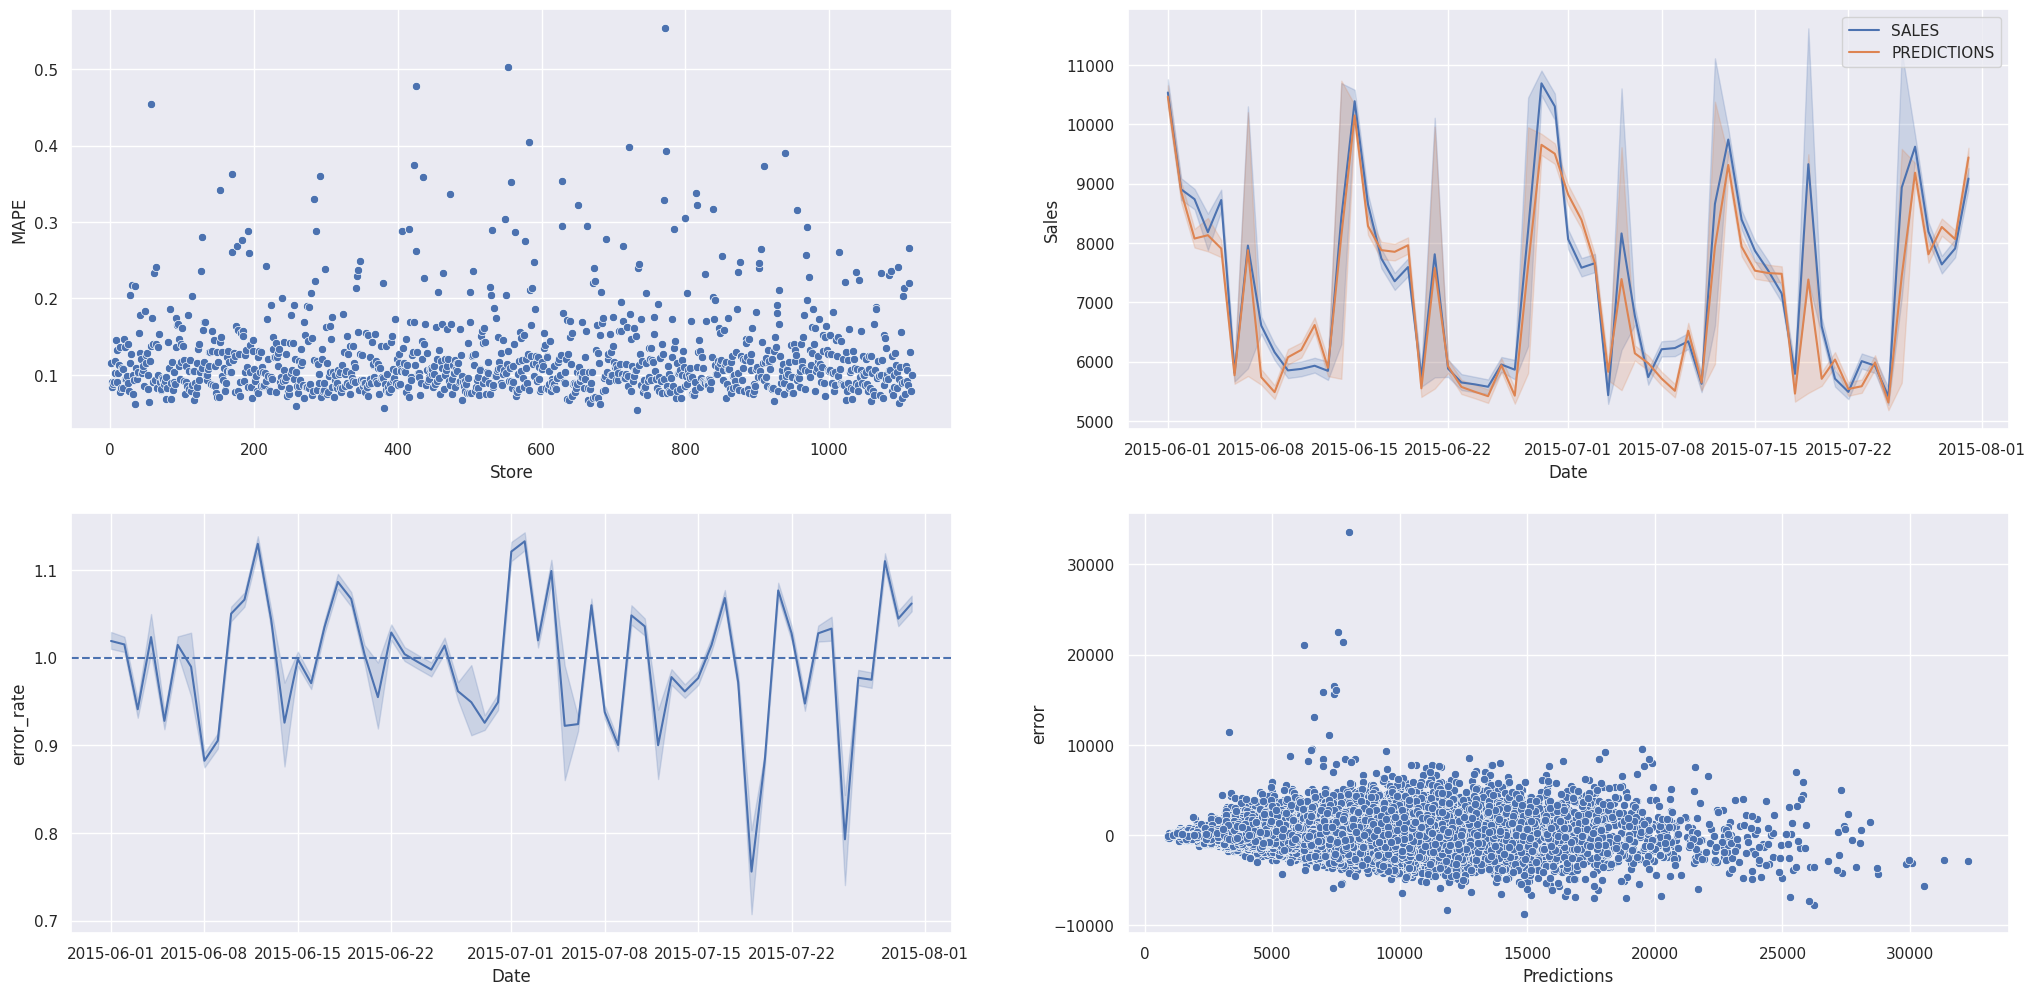

In [85]:
df9['error'] = df9['Sales'] - df9['Predictions']
df9['error_rate'] = df9['Predictions'] / df9['Sales']

#distribuição do erro MAPE em relação as lojas
plt.subplot( 2, 2, 1 )
sns.scatterplot( x='Store', y='MAPE', data=dfPredFull );

#plotagem das vendas e predições
plt.subplot( 2, 2, 2 )
sns.lineplot( x='Date', y='Sales', data=df9, label='SALES' )
sns.lineplot( x='Date', y='Predictions', data=df9, label='PREDICTIONS' )

#proporção previsão/vendas para saber se o modelo superestimou ou subestimou os valores
plt.subplot( 2, 2, 3 )
sns.lineplot( x='Date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

#erro em valor bruto em relação a predições
#destacam-se erros maiores entre previsões de 5k e 10k
plt.subplot( 2, 2, 4 )
sns.scatterplot( x = df9['Predictions'], y= df9['error'] ,data=df9 );
df9.to_csv('/home/aroldo/repos/dsprod/data/analiseErros.csv')